<img src='images/vpython.png' width="230px">

# <font color='#333333'>Titanic: will they survive?<font>
## <font color='#333333'>A Vertica ML Python tutorial to understand how to use the library.<font>

During the night of 14 April 1912, Something really unusual arrives. The passengers of the biggest boat in the world were enjoying their trip until shouts, sounds of running feet and alarms sounding removed their happiness. 
The Titanic sank and left behind it a lot of deaths. What happened ? This question is a mystery for the people who were not there. The purpose is to discover the truth thanks to the data we got before the embarkment. We know the information of 1300 passengers and we know if they survived after the sinking.

<img src='images/titanic.png' width="600px">

### <font color='#555555'>Connection to the Vertica Database using ODBC.<font>
    
In order to use the Vertica ML Python Library and begin the searches, we need first to connect to the Vertica Database. We can use an ODBC connection using pyodbc.

We can import all the information.

In [1]:
# import pyodbc
# driver="/Library/Vertica/ODBC/lib/libverticaodbc.dylib"
# server="10.211.55.14"
# database="testdb"
# port="5433"
# uid="dbadmin"
# pwd="XxX"
# dsn=("DRIVER={};SERVER={};DATABASE={};PORT={};UID={};PWD={};").format(
#            driver,server,database,port,uid,pwd)
# cur=pyodbc.connect(dsn).cursor() # It is the cursor used for all the queries to our Database.

Or simply use a DSN.

In [2]:
import pyodbc
cur=pyodbc.connect("DSN=VerticaDSN").cursor()

### <font color='#555555'>Connection using JDBC<font>
We can also use a jdbc connection using jaydebeapi.

In [3]:
# import jaydebeapi
# uid="dbadmin"
# pwd="XxX"
# driver="/Library/Vertica/JDBC/vertica-jdbc-9.0.1-0.jar" #Path to JDBC Driver
# url='jdbc:vertica://10.211.55.14:5433/'
# name='com.vertica.jdbc.Driver'
# connection=jaydebeapi.connect(name,[url,uid,pwd],driver)
# cur=connection.cursor()

### <font color='#555555'>Initialization<font>

We can now import the Vertica ML Python library and especially the RVD (Resilient Vertica Dataset) object.

In [4]:
from vertica_ml_python import RVD
from vertica_ml_python import read_csv # This function will help us to load the csv file in the Database.
from vertica_ml_python import drop_table # This function will help us to drop the unnecessary tables. 

Let's now drop the table titanic from our Database (if it exists) in order to use the read_csv parser.

In [5]:
drop_table("titanic",cur)

The table titanic was successfully dropped.


Let's now try to parse the csv files.
We can see that the type of boat is incorrect. However let's skip it, the parser will convert it automatically to varchar(30).

In [6]:
titanic=read_csv('../datasets/titanic.csv',cur)

The parser guess the following columns and types:
age: Numeric(6,3)
boat: Integer
body: Integer
cabin: Varchar(30)
embarked: Varchar(20)
fare: Numeric(10,5)
home.dest: Varchar(100)
name: Varchar(164)
parch: Integer
pclass: Integer
sex: Varchar(20)
sibsp: Integer
survived: Integer
ticket: Varchar(36)
Illegal characters in the columns names will be erased.
Is any type wrong?
If one of the types is not correct, it will be considered as Varchar(100).
0 - There is one type that I want to modify.
1 - I wish to continue.
2 - I wish to see the columns and their types again.
1
/!\ Warning: Type of boat was changed to Varchar(100)
The table titanic has been successfully created.


If the table is already in the Database. We can create the RVD as follows:

In [7]:
titanic=RVD('titanic',cur)

The cursor will be used in order to set the connection to the Vertica DB. The simplest way is to use a dsn and use it directly in the RVD creation.

In [8]:
titanic=RVD('titanic',dsn="VerticaDSN")

This command will use pyodbc in order to create a cursor using the dsn information. The two main advantages of this method is the easy way of creation and it will increase the RVD robustness adding a method called 'dsn_restart' which will easily create a new cursor if the connection is lost.

In [9]:
titanic.dsn_restart()

Let's see if our Vertica version can be used for what we ant to achieve.

In [10]:
titanic.version()

############################################################################################################
#  __ __   ___ ____  ______ ____   __  ____      ___ ___ _          ____  __ __ ______ __ __  ___  ____    #
# |  |  | /  _|    \|      |    | /  ]/    |    |   |   | |        |    \|  |  |      |  |  |/   \|    \   #
# |  |  |/  [_|  D  |      ||  | /  /|  o  |    | _   _ | |        |  o  |  |  |      |  |  |     |  _  |  #
# |  |  |    _|    /|_|  |_||  |/  / |     |    |  \_/  | |___     |   _/|  ~  |_|  |_|  _  |  O  |  |  |  #
# |  :  |   [_|    \  |  |  |  /   \_|  _  |    |   |   |     |    |  |  |___, | |  | |  |  |     |  |  |  #
#  \   /|     |  .  \ |  |  |  \     |  |  |    |   |   |     |    |  |  |     | |  | |  |  |     |  |  |  #
#   \_/ |_____|__|\_| |__| |____\____|__|__|    |___|___|_____|    |__|  |____/  |__| |__|__|\___/|__|__|  #
#                                                                                                          #
###################

(9, 0)

Perfect, let's begin.

### <font color='#555555'>Memory comparaison between pandas.Dataframe and vertica_ml_python.RVD<font>
Let's compare pandas df and RVD in terms of memory.

In [11]:
import pandas
conn=pyodbc.connect("DSN=VerticaDSN")
titanicDF=pandas.read_sql("select * from titanic",conn)
import sys
print(sys.getsizeof(titanicDF))

597049


In [12]:
print(sys.getsizeof(titanic))

56


As we don't load data in memory (everything is store inside the DB), this number will never change... It is a real difference.

### <font color='#555555'>Data Exploration and Cleaning<font>

Great, we have now our RVD object. All its methods will send SQL queries directly to Vertica in order to compute all the aggregations needed. In that case, nothing is loaded inside our machine except the final results computed by Vertica. All the users transformations are kept in mind and then used to send the final query. The following figure sums up the RVD object.

<img src="images/RVD.png" width="600px">

During this tutorial, we will try to understand the object thanks to this small dataset. Let's first see what it looks like.

In [13]:
titanic.head(5)
titanic.dtypes()

,age,boat,body,cabin,embarked,fare,homedest,name,parch,pclass,sex,sibsp,survived,ticket
0,29.000,2,None,B5,S,211.33750,"St Louis, MO","Allen, Miss. Elisabeth Walton",0,1,female,0,1,24160
1,0.920,11,None,C22 C26,S,151.55000,"Montreal, PQ / Chesterville, ON","Allison, Master. Hudson Trevor",2,1,male,1,1,113781
2,2.000,None,None,C22 C26,S,151.55000,"Montreal, PQ / Chesterville, ON","Allison, Miss. Helen Loraine",2,1,female,1,0,113781
3,30.000,None,135,C22 C26,S,151.55000,"Montreal, PQ / Chesterville, ON","Allison, Mr. Hudson Joshua Creighton",2,1,male,1,0,113781
4,25.000,None,None,C22 C26,S,151.55000,"Montreal, PQ / Chesterville, ON","Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",2,1,female,1,0,113781
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Name: titanic, Number of rows: 1309, Number of columns: 14


,type
age,"numeric(6,3)"
boat,varchar(100)
body,int
cabin,varchar(30)
embarked,varchar(20)
fare,"numeric(10,5)"
homedest,varchar(100)
name,varchar(164)
parch,int
pclass,int


Name: titanic,Number of rows: 1309,Number of columns: 14


Interesting... We can see that some of the columns are numerical (they can be used for all the analytic part). However the others are useless in the current situation. Besides, as we noticed RVD uses some HTML to have a beautiful output with IPython.

To understand the RVD, let's give more details about these columns.
<ul>
<li><b>pclass</b>: Passenger Class 
<li><b>survived</b>: 1 if the passenger survived else 0
<li><b>name</b>: Name
<li><b>sex</b>: Sex
<li><b>age</b>: Age in years, new borns have an age between 0 and 1
<li><b>sibsp</b>: Number of Sibling/Spouses aboard
<li><b>parch</b>: Number of Parents/Children aboard
<li><b>ticket</b>: Ticket Number
<li><b>fare</b>: Passenger Fare
<li><b>cabin</b>: Cabin
<li><b>embarked</b>: Port of Embarkation (C for Cherbourg, Q for Queenstown and S for Southampton)
<li><b>boat</b>: Lifeboat number
<li><b>body</b>: Body number
<li><b>homedest</b>: Home or Destination
</ul>
Let's see the mathematical summary of the numerical columns:

In [14]:
titanic.describe()

,count,mean,std,min,25%,50%,75%,max,cardinality
age,1046,29.881137667304,14.4134932112713,0.17,21.0,28.0,39.0,80.0,98
body,121,160.809917355372,97.6969219960031,1.0,72.0,155.0,256.0,328.0,121
fare,1308,33.2954792813456,51.7586682391742,0.0,7.8958,14.4542,31.275,512.3292,281
parch,1309,0.385026737967914,0.865560275349514,0.0,0.0,0.0,0.0,9.0,8
pclass,1309,2.29488158899923,0.837836018970127,1.0,2.0,3.0,3.0,3.0,3
sibsp,1309,0.498854087089382,1.0416583905961,0.0,0.0,0.0,1.0,8.0,7
survived,1309,0.381970970206265,0.486055170866483,0.0,0.0,0.0,1.0,1.0,2


<column_matrix>

All the columns seem to have correct information but a lot of ones seem to be useless. Let's now see the missing values.

In [15]:
titanic.missing()

,total,percent
body,1188,0.908
cabin,1014,0.775
boat,823,0.629
homedest,564,0.431
age,263,0.201
embarked,2,0.002
fare,1,0.001
name,0,0.0
ticket,0,0.0
pclass,0,0.0


<column_matrix>

The columns body, cabin, boat and homedest have too much of missing values. We can drop them from our RVD (our titanic table will never be modified: all the actions are only on our RVD).

In [16]:
titanic["body"].drop_column()
titanic["cabin"].drop_column()
titanic["boat"].drop_column()
titanic["homedest"].drop_column()

RVC 'body' deleted from the RVD.
RVC 'cabin' deleted from the RVD.
RVC 'boat' deleted from the RVD.
RVC 'homedest' deleted from the RVD.


The column "sex" has not a suitable name. Let's rename it. 

In [17]:
titanic["sex"].rename('gender')

RVC 'sex' renamed 'gender'


Let's now see what the columns ticket and gender look like.

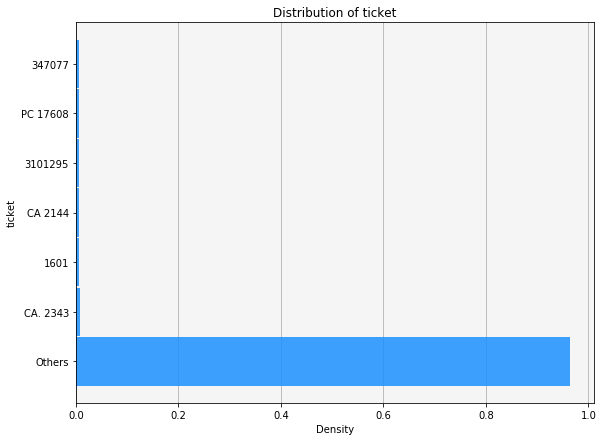

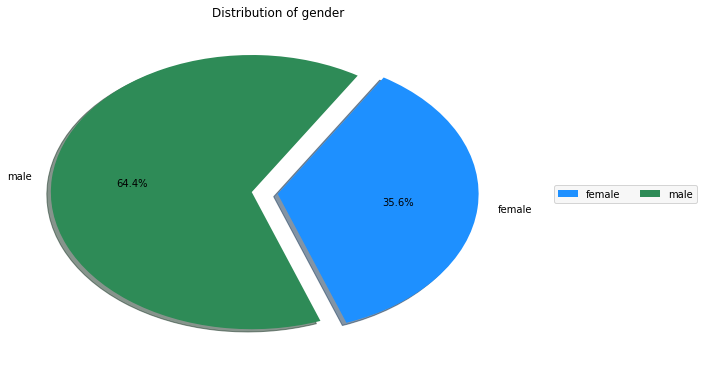

In [18]:
titanic["ticket"].bar()
titanic["gender"].pie()

The column ticket will be useless and will not give real details of what happened. Let's drop this column. The column gender seems very interesting. We can convert it to numerical using a dummy encode.

In [19]:
titanic["ticket"].drop_column()
titanic["gender"].label_encode()

RVC 'ticket' deleted from the RVD.


gender,encoding
female,0
male,1


The label encoding was successfully done.


Let's now see again our RVD.

In [20]:
titanic.dtypes()

,type
age,"numeric(6,3)"
embarked,varchar(20)
fare,"numeric(10,5)"
name,varchar(164)
parch,int
pclass,int
sibsp,int
survived,int
gender,int


Name: titanic,Number of rows: 1309,Number of columns: 9


We didn't yet explored the column embarked. Let's see what it looks like.

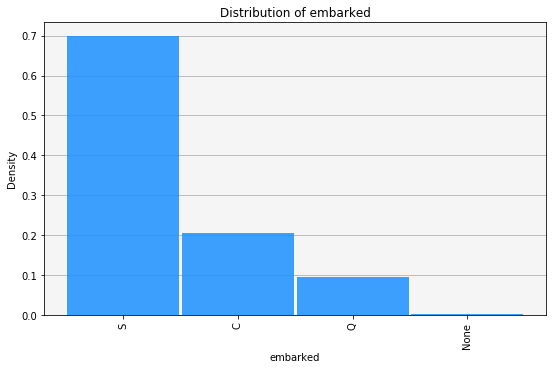

,value
S,914
C,270
Q,123
None,2


<column_matrix>

In [21]:
titanic["embarked"].hist()
titanic["embarked"].describe()

It has 2 missing values. As the number is very small, we can delete them and we can then use a dummy encode in order to have a numerical column.

In [22]:
titanic["embarked"].dropna()
titanic["embarked"].label_encode()

2 elements were dropped


embarked,encoding
Q,0
C,1
S,2


The label encoding was successfully done.


The column name can be useful (see after) but let's drop it for our first model.

In [23]:
titanic["name"].drop_column()

RVC 'name' deleted from the RVD.


Let's now see again our RVD and specially the missing values.

In [24]:
titanic.missing()

,total,percent
age,263,0.201
fare,1,0.001
parch,0,0.0
survived,0,0.0
sibsp,0,0.0
pclass,0,0.0
embarked,0,0.0
gender,0,0.0


<column_matrix>

We can delete the only missing value of fare and impute the missing ages with the average age of passengers having the same gender and the same class. We can contest this way of imputing, however we must choose how to impute the missing values in order to use this column.

In [25]:
titanic["fare"].dropna()
titanic["age"].fillna(method="avg",by=["pclass","gender"])
titanic.missing()

1 element was dropped
263 elements were filled


,total,percent
embarked,0,0.0
age,0,0.0
pclass,0,0.0
fare,0,0.0
sibsp,0,0.0
survived,0,0.0
parch,0,0.0
gender,0,0.0


<column_matrix>

Now that we have done a lot of imputations, let's see the history of the modifications using the 'history' method.

In [26]:
titanic.history()

The RVD was modified many times: 
 * {Tue May  8 23:57:22 2018} [Drop Column]: RVC 'body' was deleted from the RVD.
 * {Tue May  8 23:57:22 2018} [Drop Column]: RVC 'cabin' was deleted from the RVD.
 * {Tue May  8 23:57:22 2018} [Drop Column]: RVC 'boat' was deleted from the RVD.
 * {Tue May  8 23:57:22 2018} [Drop Column]: RVC 'homedest' was deleted from the RVD.
 * {Tue May  8 23:57:22 2018} [Rename]: The RVC 'sex' was renamed 'gender'.
 * {Tue May  8 23:57:24 2018} [Drop Column]: RVC 'ticket' was deleted from the RVD.
 * {Tue May  8 23:57:24 2018} [Label Encode]: The RVC 'gender' was transformed with the 'label encoding'.
	female => 0
	male => 1
	others => NULL
 * {Tue May  8 23:57:25 2018} [Dropna]: The 2 missing elements of column 'embarked' were dropped from the RVD.
 * {Tue May  8 23:57:25 2018} [Label Encode]: The RVC 'embarked' was transformed with the 'label encoding'.
	Q => 0
	C => 1
	S => 2
	others => NULL
 * {Tue May  8 23:57:25 2018} [Drop Column]: RVC 'name' was deleted 

Wow many modifications ! We can also see the current RVD virtual table.

In [27]:
titanic.current_table()

"(select * from (select coalesce(age,avg(age) over (partition by pclass,gender)) as age, decode(embarked,'Q',0,'C',1,'S',2,NULL) as embarked, fare as fare, parch as parch, pclass as pclass, sibsp as sibsp, survived as survived, decode(gender,'female',0,'male',1,NULL) as gender from (select age as age, embarked as embarked, fare as fare, parch as parch, pclass as pclass, sibsp as sibsp, survived as survived, sex as gender from titanic) t1 where embarked is not null and fare is not null offset 0) t2) new_table"

We can also see all the request made by the RVD and the elapsed time using the following methods.

In [28]:
titanic.sql_on_off(reindent=True) # reindent using sqlparse
titanic.time_on_off()
titanic.describe()

,count,mean,std,min,25%,50%,75%,max,cardinality
age,1306,29.3081618574827,13.1245109908118,0.17,22.0,26.0,36.375,80.0,103
embarked,1306,1.60490045941807,0.653976130570613,0.0,1.0,2.0,2.0,2.0,3
fare,1306,33.2239562787137,51.7659859035533,0.0,7.8958,14.4542,31.275,512.3292,280
gender,1306,0.644716692189892,0.478782415787712,0.0,0.0,1.0,1.0,1.0,2
parch,1306,0.385911179173047,0.86635748936828,0.0,0.0,0.0,0.0,9.0,8
pclass,1306,2.29632465543645,0.837036534239803,1.0,2.0,3.0,3.0,3.0,3
sibsp,1306,0.5,1.04258005931277,0.0,0.0,0.0,1.0,8.0,7
survived,1306,0.381316998468606,0.485896205401395,0.0,0.0,0.0,1.0,1.0,2


<column_matrix>

Do not forget to turn it off.

In [29]:
titanic.sql_on_off(reindent=True)
titanic.time_on_off()

Let's now try to detect the outliers. The only columns that can have ones are fare and age as the others are categorical.

In [30]:
titanic["age"].outliers()

,age,normalized_age
0,80.0,3.86237919096611
1,76.0,3.55760593100996
2,74.0,3.40521930103189
3,71.0,3.17663935606478
4,71.0,3.17663935606478
5,70.5,3.13854269857026
6,70.0,3.10044604107574
7,70.0,3.10044604107574


Total of 8 outliers detected.


8 outliers but they seem to be real passengers (just old ones...). Let's now see for fare.

In [31]:
titanic["fare"].outliers()

,fare,normalized_fare
0,512.32920,9.25521334827702
1,512.32920,9.25521334827702
2,512.32920,9.25521334827702
3,512.32920,9.25521334827702
4,263.00000,4.43874563017864
5,263.00000,4.43874563017864
6,263.00000,4.43874563017864
7,263.00000,4.43874563017864
8,263.00000,4.43874563017864
9,263.00000,4.43874563017864


Total of 10 outliers detected.


Some have spend too much money... However they are not really outliers... <br>
We can now create a new feature as parch+sibsp+1 corresponds to the family size. Let's see if this feature has a real influence.

In [32]:
titanic.add_feature(alias="family_size",imputation="parch+sibsp+1")

The new RVC 'family_size' was added to the RVD.


When this new feature is created, the columns attribute of the RVD titanic will receives a new RVC having as name "family_size" and as imputed column "parch+sibsp+1". The operation is easy and the RVD will control if the imputation make sense before adding the RVC in order to avoid futur problems.
Okay! We have now a really cleaned dataset. Let's explore it a little bit deeper by seeing the correlation matrix.

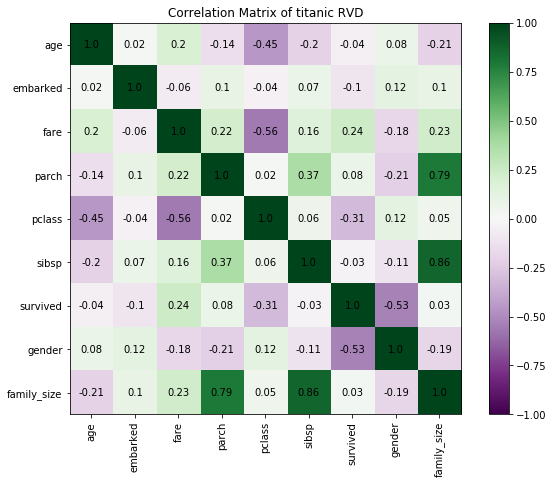

,age,embarked,fare,parch,pclass,sibsp,survived,gender,family_size
age,1,0.019,0.196,-0.135,-0.446,-0.204,-0.04,0.081,-0.208
embarked,0.019,1,-0.062,0.096,-0.038,0.074,-0.099,0.122,0.101
fare,0.196,-0.062,1,0.222,-0.558,0.161,0.243,-0.184,0.227
parch,-0.135,0.096,0.222,1,0.018,0.373,0.083,-0.214,0.792
pclass,-0.446,-0.038,-0.558,0.018,1,0.06,-0.31,0.121,0.049
sibsp,-0.204,0.074,0.161,0.373,0.06,1,-0.027,-0.111,0.862
survived,-0.04,-0.099,0.243,0.083,-0.31,-0.027,1,-0.527,0.028
gender,0.081,0.122,-0.184,-0.214,0.121,-0.111,-0.527,1,-0.19
family_size,-0.208,0.101,0.227,0.792,0.049,0.862,0.028,-0.19,1


<column_matrix>

In [33]:
titanic.corr()

Passengers survival seem to be very dependant to the gender, the passenger class and the fare. However, the RVD has only three non-categorical variables. Let's do a little scatter plot of these three (including the column survived).

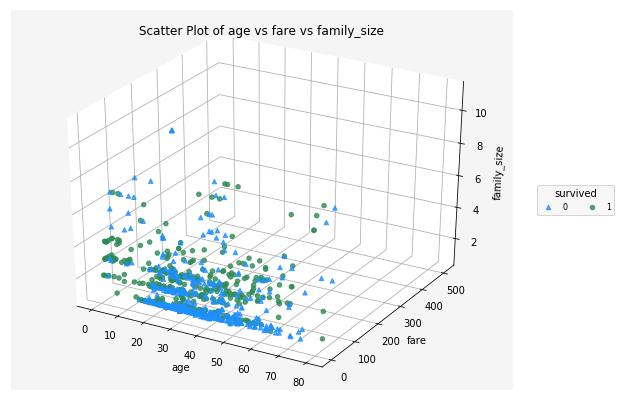

In [34]:
titanic.scatter3D(columns=["age","fare","family_size","survived"])

We can see a real separation between rich passengers having a small family size and the others. Let's try to have more information by drawing an hexbin plot.

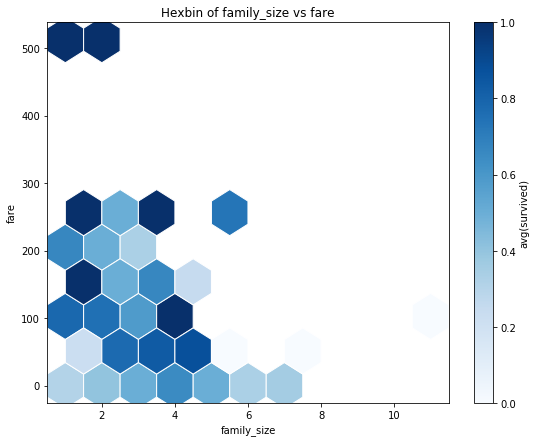

In [35]:
titanic.hexbin(columns=["family_size","fare"],method="avg",of="survived")

That's what we expected. The fewer the family size is, the greater the probability of dying is. Besides, people who had spent expensive fares have greater chances of surviving. Let's try to validate the hypothesis with a boxplot.

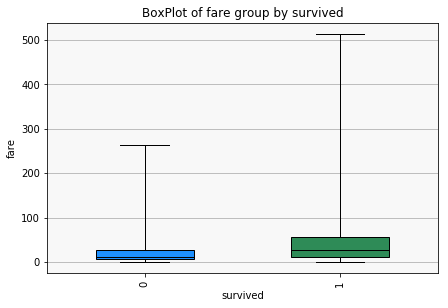

In [36]:
titanic["fare"].boxplot(by="survived")

There is a real link between fare and survived! We can really see the importance of this column using bivariate histograms.

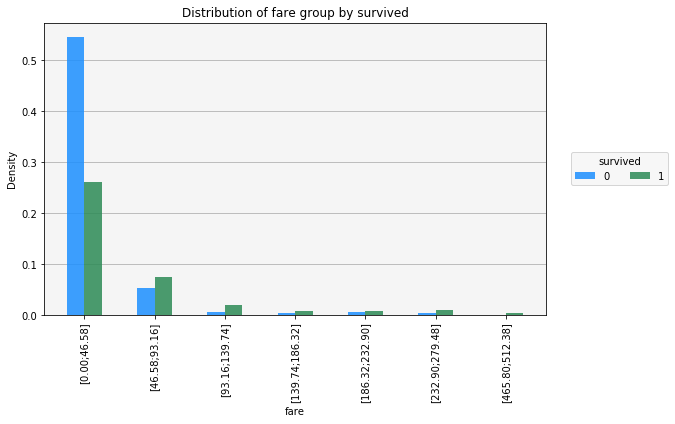

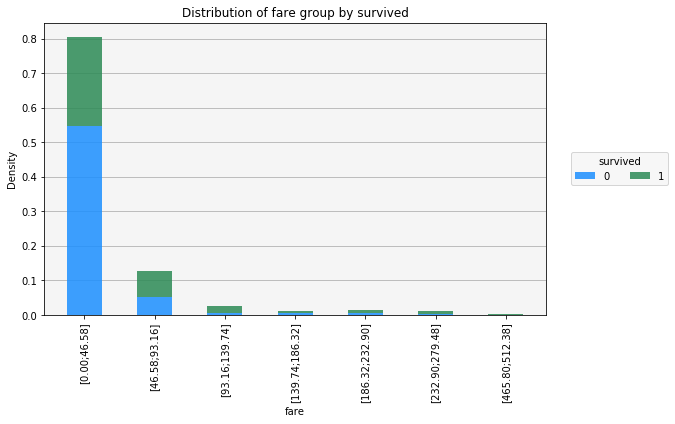

In [37]:
titanic.hist(columns=["fare","survived"])
titanic.stacked_hist(columns=["fare","survived"])

Or just simply with a pivot table...

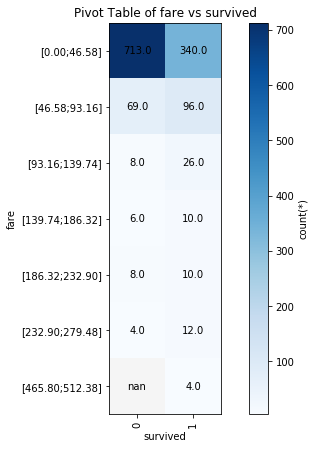

fare/survived,0,1
[0.00;46.58],713,340
[46.58;93.16],69,96
[93.16;139.74],8,26
[139.74;186.32],6,10
[186.32;232.90],8,10
[232.90;279.48],4,12
[465.80;512.38],,4


<column_matrix>

In [38]:
titanic.pivot_table(columns=["fare","survived"])

Let's now see the importance of the other columns.

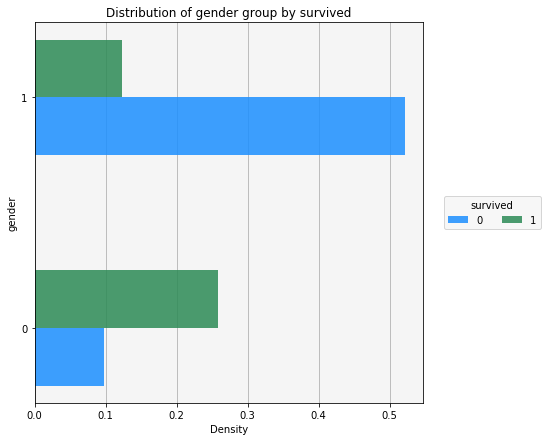

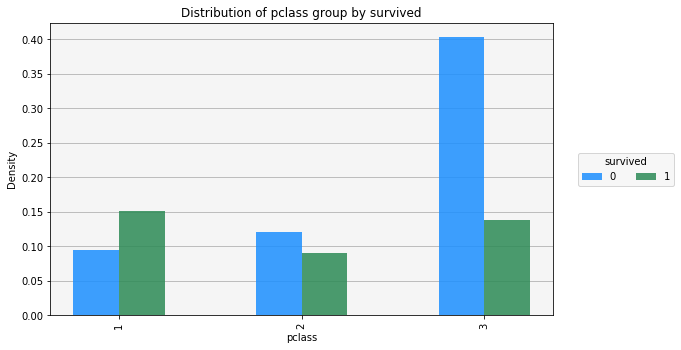

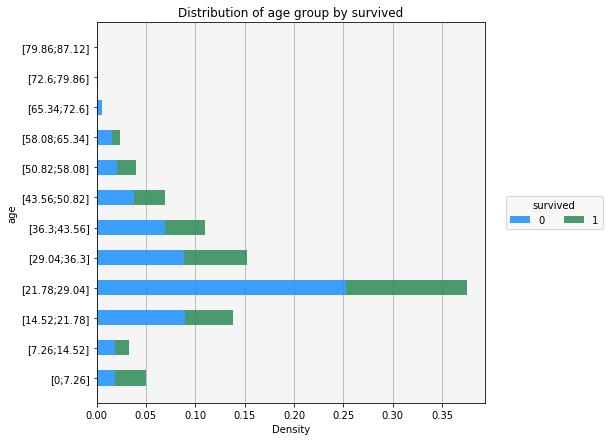

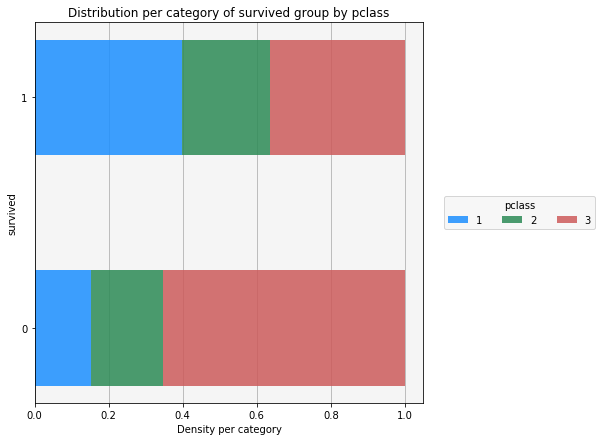

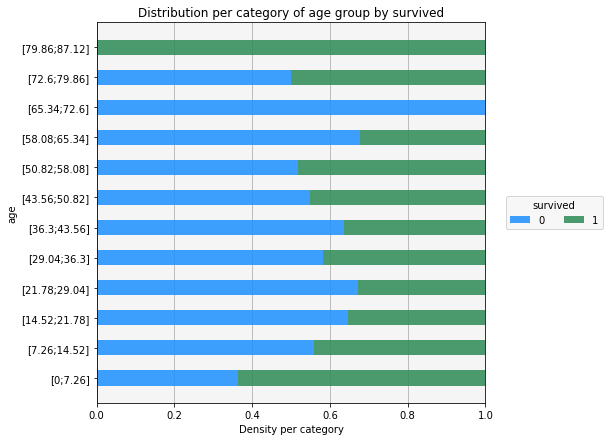

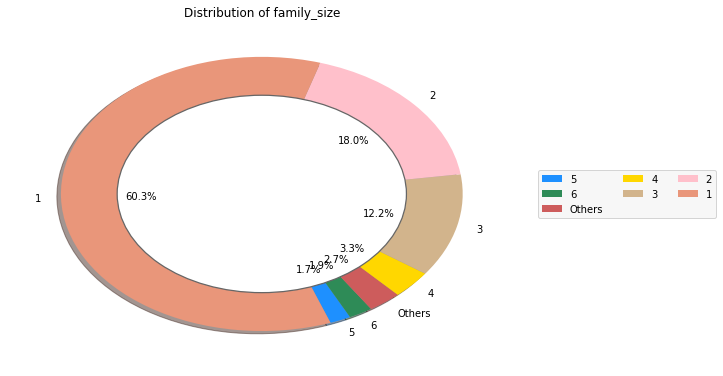

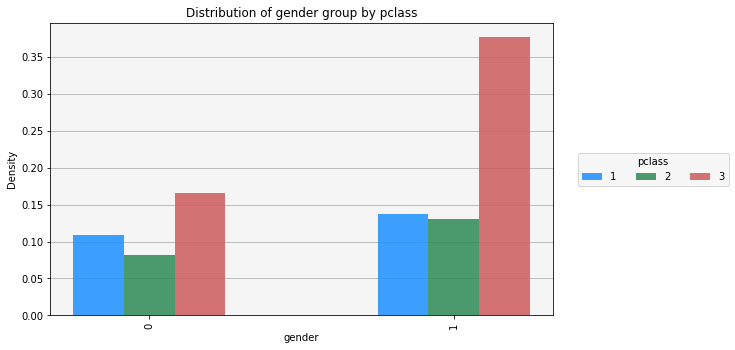

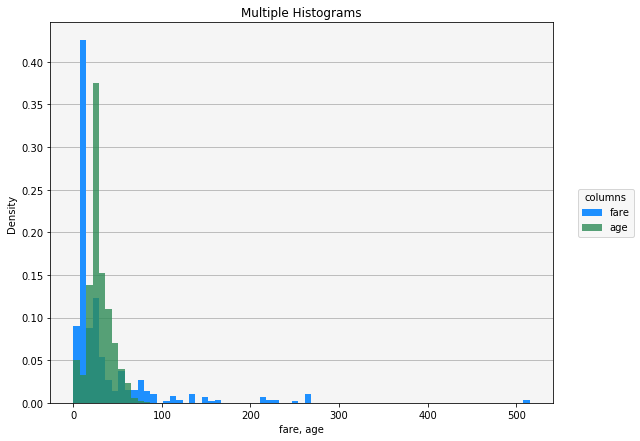

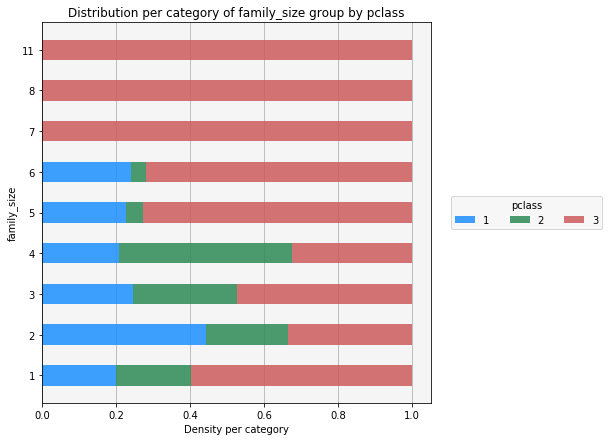

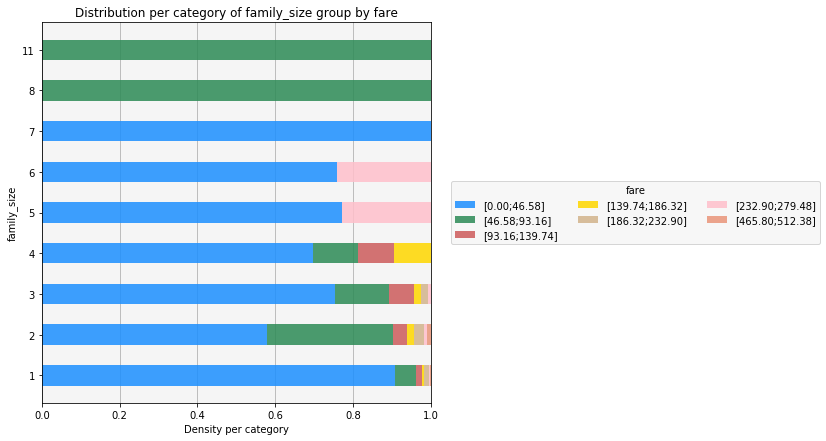

In [39]:
titanic.bar(columns=["gender","survived"])
titanic.hist(columns=["pclass","survived"])
titanic.stacked_bar(columns=["age","survived"])
titanic.fully_stacked_bar(columns=["survived","pclass"])
titanic.fully_stacked_bar(columns=["age","survived"])
titanic["family_size"].donut()
titanic.hist(columns=["gender","pclass"])
titanic.multiple_hist(columns=["fare","age"])
titanic.fully_stacked_bar(columns=["family_size","pclass"])
titanic.fully_stacked_bar(columns=["family_size","fare"])

To put it in a nutshell, we can say that women, children, people in first class and people having a small family size have bigger chances to survive. We can now try to build a model in order to confirm these hypothesis.

### <font color='#555555'>Choosing a model to predict the survivors<font>
    
Having all these informations, we need a binomial model. In Vertica, four models can be used in this case:
<ul>
    <li>Logistic Regression
    <li>Naive Bayes
    <li>Random Forest
    <li>SVM
</ul>
Let's try a Logistic Regression as it seems suitable in this case. <br>
Logistic regression, or Logit regression, is a regression model where the dependent variable is categorical and the independent variables or predictors can be continuous, categorical or a mix of both.
The heart of the Logit Regression is the standard logistic function:
$$y=\frac{1}{1+e^{-x}}$$
where y is our dependent variable and x is built starting from the independent variables using this equation:
$$x=a_0+a_1x_1+a_2x_2+...$$
In our case:
$$x=a_0+a_1*pclass+a_2*age+...$$
The standard logistic function has a typical S-curve shape (sigmoid curve) ranging in $[0,1]$.

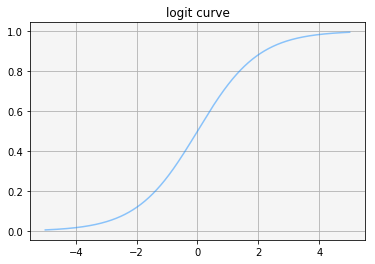

In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt

def logit(x):
    return 1/(1+math.exp(-x))
x=np.linspace(-5,5,num=1000)
y=[logit(item) for item in x]

plt.gca().grid()
plt.gca().set_axisbelow(True)
plt.title("logit curve")
x=plt.plot(x,y,alpha=0.5,color="dodgerblue")

Machine Learning with Logistic Regression is a two-step process:
<ul>
<li> The scope of this first (learning) phase is to find the best values for the coefficients using a train data set where both independent and dependent variables (predictors and outcome) are known.
<li> We can compute the corresponding logistic function. A binary response will be "1" or "0" depending on $y > t$ being true or not. t is named the threshold and is usually set to $0.5$
</ul>

### <font color='#555555'>Creating the Model<font>

The first step is to split our RVD into a test and a train set.

In [41]:
titanic.train_test_split()

The views test_titanic033 and train_titanic067 were successfully created.


,age,embarked,fare,parch,pclass,sibsp,survived,gender,family_size
0,76.0,2,78.85000,0,1,1,1,0,2
1,63.0,2,221.77920,0,1,1,0,0,2
2,63.0,2,77.95830,0,1,1,1,0,2
3,60.0,1,76.29170,0,1,0,1,0,1
4,60.0,1,75.25000,0,1,1,1,0,2
5,59.0,2,51.47920,0,1,2,1,0,3
6,58.0,2,26.55000,0,1,0,1,0,1
7,58.0,1,512.32920,1,1,0,1,0,2
8,56.0,1,83.15830,1,1,0,1,0,2
9,55.0,1,135.63330,0,1,0,1,0,1


,age,embarked,fare,parch,pclass,sibsp,survived,gender,family_size
0,64.0,2,26.55000,1,1,1,1,0,3
1,64.0,1,83.15830,2,1,0,1,0,3
2,60.0,2,263.00000,4,1,1,1,0,6
3,58.0,1,146.52080,0,1,0,1,0,1
4,58.0,2,153.46250,1,1,0,1,0,2
5,55.0,2,25.70000,0,1,2,1,0,3
6,54.0,1,59.40000,0,1,1,1,0,2
7,53.0,2,51.47920,0,1,2,1,0,3
8,52.0,2,93.50000,1,1,1,1,0,3
9,49.0,1,76.72920,0,1,1,1,0,2


(Name: train_titanic067, Number of rows: 862, Number of columns: 9,
 Name: test_titanic033, Number of rows: 444, Number of columns: 9)

We can then import the logistic regression model from VML. VML is a package containing all the Vertica ML functions. It provides many ML objects easy to use in order to create quickly models inside Vertica. The following figure sums up the role of VML.

<img src="images/vml.png" width="600px">

In [42]:
from vertica_ml_python import logistic_reg
from vertica_ml_python import drop_model
from vertica_ml_python import load_model

In [43]:
drop_model("lr_titanic",cur)

The model lr_titanic was successfully dropped.


In [44]:
logit=logistic_reg(model_name="lr_titanic",input_relation="train_titanic067",response_column="survived",
                   predictor_columns=["age","gender","family_size","embarked","fare","pclass"],cursor=cur)
print(logit)
coefficients=logit.details()

,coefficient,std_error,t_value,p_value
Intercept,4.88397485181215,0.586677365204033,8.32480532142844,8.44674447687093e-17
age,-0.0347705474951701,0.00768232526214005,-4.52604469463509,6.0097874973733e-06
gender,-2.39164697235406,0.188400948544658,-12.6944529251515,6.34719159375125e-37
family_size,-0.198100805188099,0.066719018884901,-2.96918043009368,0.00298595213155268
embarked,-0.224307360218314,0.138641253921166,-1.61789765942149,0.105684654790879
fare,0.00173264833035388,0.00202082681210399,0.857395755032531,0.391226204515912
pclass,-0.997092231510073,0.138741717111633,-7.18667933674052,6.63860752726033e-13


model_type='logistic_reg'
model_name='lr_titanic'
input_relation='train_titanic067'
response_column='survived'
predictor_columns='age,gender,family_size,embarked,fare,pclass'
regularization: none
lambda: 1.0
rejected_row_count: 0
accepted_row_count: 862


The equation of the logistic regression process is the following.

In [45]:
equation=str(round(coefficients.data_columns[1][1],3))
n=len(coefficients.data_columns[1])
for i in range(2,n):
    if (coefficients.data_columns[1][i]>0):
        sign="+"
    else:
        sign=""
    equation+=sign+str(round(coefficients.data_columns[1][i],3))+"*"+str(coefficients.data_columns[0][i])
print(equation)

4.884-0.035*age-2.392*gender-0.198*family_size-0.224*embarked+0.002*fare-0.997*pclass


We have then the following model:
<ul>
    <li>We compute x={{equation}}
    <li>We compute $y=\frac{1}{1+e^{-x}}$
    <li>If y>t (we can choose the threshold as we want, $t\in [0,1]$) then the response is "1" else "0"
</ul>

Now that the model is built, let's see the feature importance.

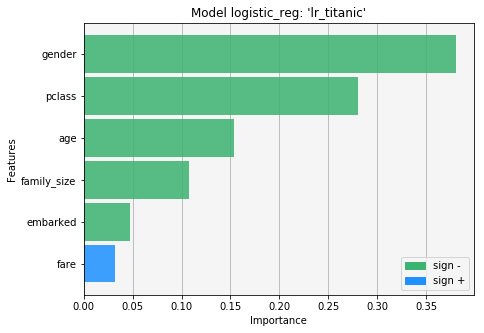

,Importance
fare,0.031955701599008624
embarked,0.047085518250526835
family_size,0.10788694467562268
age,0.1533629834637672
pclass,0.27991972197075266
gender,0.3797891300403221


<column_matrix>

In [46]:
logit.features_importance()

We can see that gender, pclass and age are the most important variables. Let's see the accuracy of our training dataset.

In [47]:
print(logit.error_rate())
accuracy=logit.accuracy()
print("\naccuracy="+str(round(accuracy*100,2))+"%")

,error_rate
0,0.139925373134328
1,0.340490797546012
total,0.215777262180974


<column_matrix>

accuracy=78.42%


Our accuracy is not bad, we have {{round(accuracy*100,2)}}% of correct predictions. However, we used the default threshold of $0.5$ and we have better prediction for class 1. A better model is more balanced. We can plot the ROC curve to choose a better threshold.

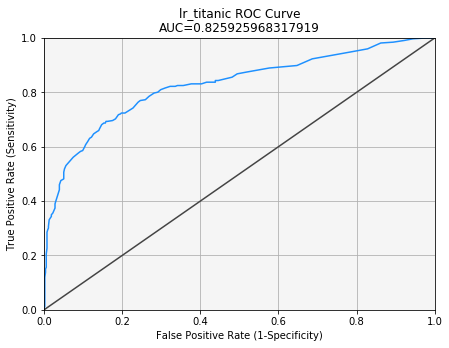

In [48]:
roc=logit.roc()
best_threshold=roc[0].data_columns[1][2]
auc=logit.auc()

Our AUC is not bad at all ({{round(auc,2)}}) ! Knowing the best threshold ({{round(best_threshold,2)}}), let's see if we improved the model.

In [49]:
print(logit.error_rate(threshold=best_threshold))
accuracy=logit.accuracy()
print("\naccuracy="+str(round(accuracy*100,2))+"%")

,error_rate
0,0.158582089552239
1,0.306748466257669
total,0.21461716937355


<column_matrix>

accuracy=78.42%


The accuracy with the best threshold is {{round(accuracy*100,2)}}%. We almost have the same accuracy but the model is more balanced. The purpose of the best threshold is to make the model as efficient and balanced as possible. <br>

We can see the confusion matrix of the model in order to see where are the wrong predictions.

In [50]:
logit.confusion_matrix(threshold=best_threshold)

,0,1
0,451,85
1,100,226


<column_matrix>

We can also see the lift table in order to select a smaller part of the dataset to build the model (here it is not necessary as our dataset is very small).

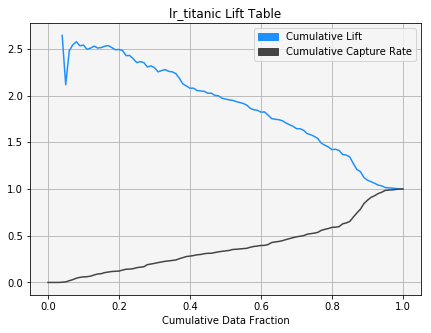

In [51]:
lift_table=logit.lift_table()

The columns embarked and fare are not very important (high p-value). We can delete them to build a new model. It is logic as it is more the passengers classes that influence their survival. The next model that we will build will be a random forest. With this kind of algorithms, we can keep the useless columns as it is not sensible to noise. <br>
Another good thing to know is that we can also add the predictions to our RVD.

The new RVC 'logistic_reg_pred8500' was added to the RVD.


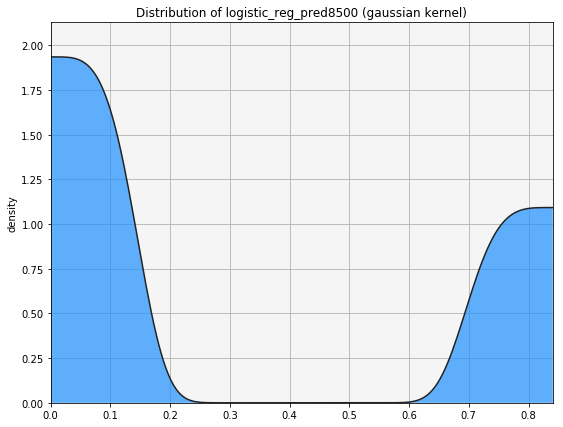

In [52]:
titanic_train=RVD("train_titanic067",cur)
name=logit.add_to_rvd(titanic_train,cutoff=best_threshold)
titanic_train[name].density()

We can see that the model is better to predict passengers who died during the sinking rather than the survivors. One important step is now to evaluate the model thanks to the test set.

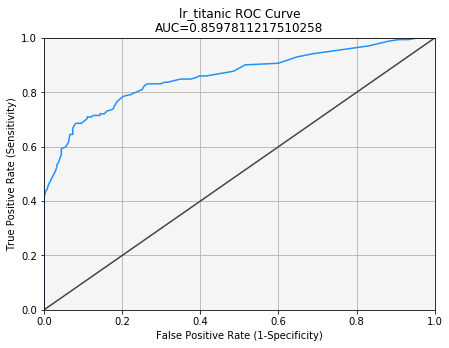

,error_rate
0,0.143382352941176
1,0.27906976744186
total,0.195945945945946


<column_matrix>


In [53]:
logit_test=load_model("lr_titanic",cur,input_relation="test_titanic033")
roc=logit_test.roc()
auc=logit_test.auc()
error=logit_test.error_rate(threshold=best_threshold)
print(error)
accuracy=logit_test.accuracy()

Good model with {{round(accuracy*100,2)}}% of good predictions and an AUC of {{round(auc,2)}} for the test dataset!

When the number of parameters is very small (1 or 2), we can also plot the Logit. Let's build a model with only one column and plot the logit.

The model lr_titanic_2 was successfully dropped.


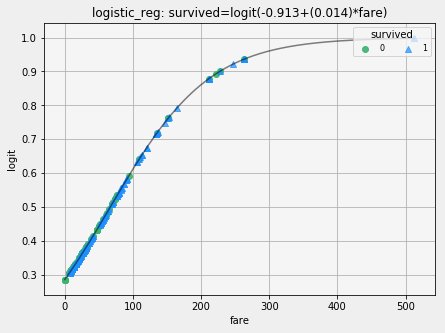

In [54]:
drop_model("lr_titanic_2",cur)
logit=logistic_reg(model_name="lr_titanic_2",input_relation="train_titanic067",response_column="survived",
                   predictor_columns=["fare"],cursor=cur)
logit.plot()

This graphic can be very useful to understand the model. Anyways, we have a lot of clues to try to create a better model. We can delete the column fare and try to create another feature. Besides, categorical variables are better for trees algorithms. A Random Forest can be very efficient for this kind of dataset.

### <font color='#555555'>Comparing metrics to scikit-learn<font>

We know that scikit-learn is limited in term of efficiency. Indeed, Vertica will always be faster than scikit-learn because the user can increase the number of nodes (what scikit-learn can not do, even if it is highly parallelized using a single node). What about performances ? Let's compare using exactly the same train and test sets.

In [55]:
import pandas
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
conn=pyodbc.connect("DSN=VerticaDSN")
number_rounds=5
vertica_accuracy=[]
vertica_auc=[]
scikit_accuracy=[]
scikit_auc=[]
for i in range(number_rounds):
    # Split the data into two views
    drop_table("random_vpython_table_titanic",cur,print_info=False)
    titanic.train_test_split(print_info=False)
    
    # Scikit
    titanic_df_train=pandas.read_sql("select * from train_titanic067",conn)
    titanic_df_test=pandas.read_sql("select * from test_titanic033",conn)
    model=LogisticRegression(max_iter=100,penalty='l2',tol=1e-4,solver='newton-cg',C=1.0)
    model.fit(titanic_df_train[["age","embarked","fare","family_size","pclass","gender"]],titanic_df_train["survived"])
    # accuracy
    predicted=model.predict(titanic_df_test[["age","embarked","fare","family_size","pclass","gender"]])
    scikit_accuracy+=[accuracy_score(predicted,titanic_df_test["survived"])]
    # auc
    response=model.predict_proba(titanic_df_test[["age","embarked","fare","family_size","pclass","gender"]])
    scikit_auc+=[roc_auc_score(titanic_df_test["survived"],[item[1] for item in response])]
    
    # Vertica
    drop_model("lr_titanic",cur,print_info=False)
    logit=logistic_reg(model_name="lr_titanic",input_relation="train_titanic067",response_column="survived",
                   predictor_columns=["age","gender","family_size","embarked","fare","pclass"],cursor=cur,
                   optimizer='Newton', epsilon=1e-4, max_iterations=100, regularization='L2', l=1.0)
    logit_test=load_model("lr_titanic",cur,input_relation="test_titanic033")
    # accuracy
    vertica_accuracy+=[logit_test.accuracy()]
    # auc
    vertica_auc+=[logit_test.auc()]    

Let's now compare the different accuracies...

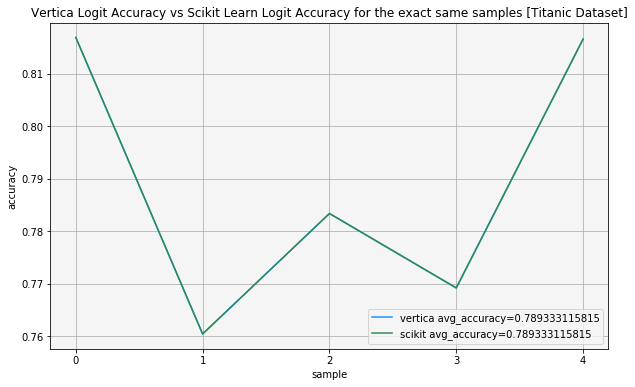

In [56]:
from matplotlib import pyplot as plt
import numpy
sample=list(range(number_rounds))

# accuracy
plt.figure(figsize=(10,6))
plt.plot(sample,vertica_accuracy,label="vertica avg_accuracy="+str(numpy.mean(vertica_accuracy)),color="dodgerblue")
plt.plot(sample,scikit_accuracy,label="scikit avg_accuracy="+str(numpy.mean(scikit_accuracy)),color="seagreen")
plt.ylabel('accuracy')
plt.xlabel('sample')
plt.legend()
plt.grid()
plt.xticks(sample,sample)
plt.title('Vertica Logit Accuracy vs Scikit Learn Logit Accuracy for the exact same samples [Titanic Dataset]')
plt.show()

And the different auc...

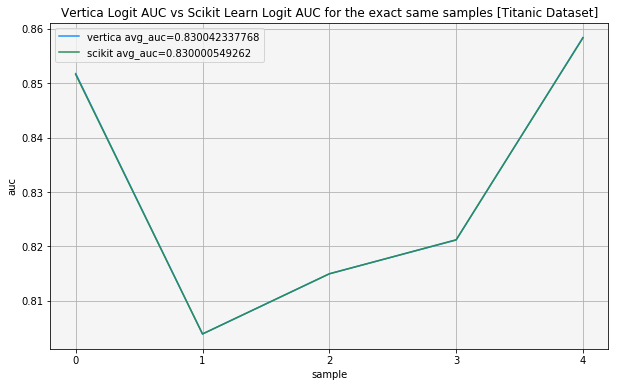

In [57]:
# auc
plt.figure(figsize=(10,6))
plt.plot(sample,vertica_auc,label="vertica avg_auc="+str(numpy.mean(vertica_auc)),color="dodgerblue")
plt.plot(sample,scikit_auc,label="scikit avg_auc="+str(numpy.mean(scikit_auc)),color="seagreen")
plt.ylabel('auc')
plt.xlabel('sample')
plt.legend()
plt.grid()
plt.xticks(sample,sample)
plt.title('Vertica Logit AUC vs Scikit Learn Logit AUC for the exact same samples [Titanic Dataset]')
plt.show()

And the winner is...
<br>
<br>
<img src="images/draw_match.png" width="600px">
<br>
<br>
The two performances are totally similar (indeed, the logistic regression algorithm is quite easy to implement). As Vertica is much more efficient, we can say that Vertica Logit is better than Scikit Logit (the user can add as many nodes he wants whereas in scikit it is not possible).

### <font color='#555555'>Creating a better model<font>

First, we can delete the useless feature (boat, ticket...), impute the missing values...

In [58]:
titanic=RVD('titanic',cur)
titanic.drop_columns(columns=["body","cabin","boat","homedest","ticket"])
titanic.add_feature(alias="family_size",imputation="parch+sibsp+1")
titanic["sex"].rename("gender")
titanic["age"].fillna(method="avg",by=["pclass","gender"])

RVC 'body' deleted from the RVD.
RVC 'cabin' deleted from the RVD.
RVC 'boat' deleted from the RVD.
RVC 'homedest' deleted from the RVD.
RVC 'ticket' deleted from the RVD.
The new RVC 'family_size' was added to the RVD.
RVC 'sex' renamed 'gender'
263 elements were filled


The column name can have some very usefull information. Indeed, we can know the title of the passengers (Miss, Master, Mr., Mrs., Dr., Capt., Major., ...)

In [59]:
titanic["name"].head(n=10)

,name
0,"Salomon, Mr. Abraham L"
1,"Keane, Miss. Nora A"
2,"Thorneycroft, Mrs. Percival (Florence Kate White)"
3,"Leitch, Miss. Jessie Wills"
4,"Riordan, Miss. Johanna ""Hannah"""
5,"Smyth, Miss. Julia"
6,"Glynn, Miss. Mary Agatha"
7,"McDermott, Miss. Brigdet Delia"
8,"O'Leary, Miss. Hanora ""Norah"""
9,"McGovern, Miss. Mary"


<column_matrix>


Let's extract the title and explore the new feature. 

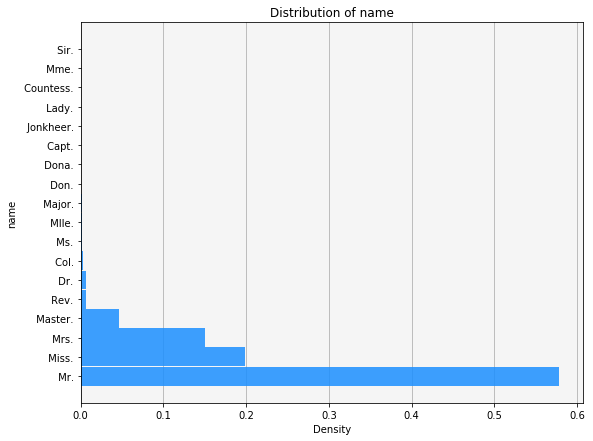

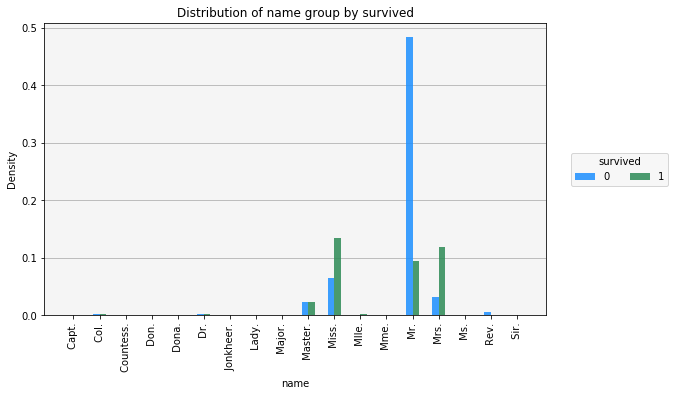

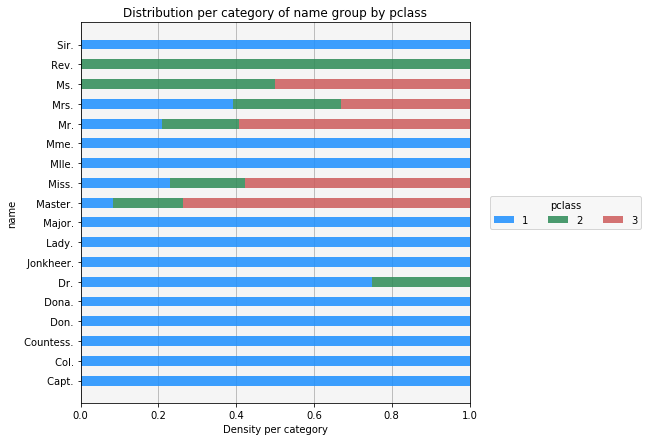

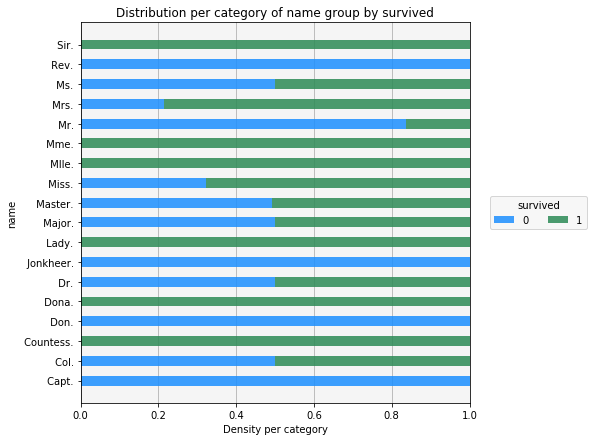

,value
Mr.,757
Miss.,260
Mrs.,197
Master.,61
Rev.,8
Dr.,8
Col.,4
Ms.,2
Mlle.,2
Major.,2


<column_matrix>

In [60]:
titanic["name"].regexp_substr(' ([A-Za-z]+)\.')
titanic["name"].bar(max_cardinality=30)
titanic.hist(columns=["name","survived"])
titanic.fully_stacked_bar(columns=["name","pclass"])
titanic.fully_stacked_bar(columns=["name","survived"])
titanic["name"].describe(max_cardinality=100)

We can still improve this variable by merging some similar title (Mme=Mrs, Mlle=Miss, Mr=Sir...).

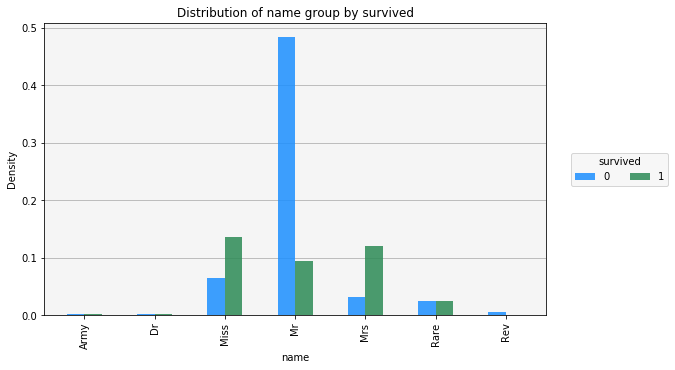

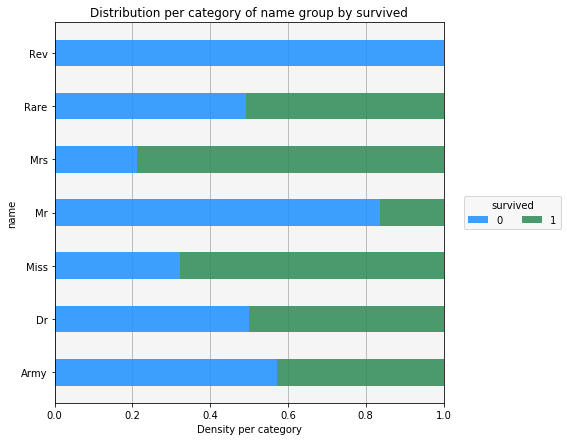

In [61]:
titanic["name"].decode([" Mr."," Miss."," Mrs."," Ms."," Mlle."," Lady."," Mme."," Sir."," Rev."," Dr."," Col."," Major."," Capt."],
                        ["Mr","Miss","Mrs","Miss","Miss","Mrs","Mrs","Mr","Rev","Dr","Army","Army","Army"],"Rare")
titanic.hist(columns=["name","survived"])
titanic.fully_stacked_bar(columns=["name","survived"])

We can also see if the title is correlated to other variables. In order to do so, we need to encode all the title using a one hot encoder.

In [62]:
titanic["name"].one_hot_encoder()

7 new features: name_Army, name_Dr, name_Miss, name_Mr, name_Mrs, name_Rare, name_Rev


In [63]:
titanic.select(['pclass','survived','name','name_Army','name_Dr','name_Miss','name_Mr','name_Mrs','name_Rare','name_Rev'])

,pclass,survived,name,name_Army,name_Dr,name_Miss,name_Mr,name_Mrs,name_Rare,name_Rev
0,1,1,Mr,0,0,0,1,0,0,0
1,2,1,Miss,0,0,1,0,0,0,0
2,3,1,Mrs,0,0,0,0,1,0,0
3,2,1,Miss,0,0,1,0,0,0,0
4,3,1,Miss,0,0,1,0,0,0,0
5,3,1,Miss,0,0,1,0,0,0,0
6,3,1,Miss,0,0,1,0,0,0,0
7,3,1,Miss,0,0,1,0,0,0,0
8,3,1,Miss,0,0,1,0,0,0,0
9,3,1,Miss,0,0,1,0,0,0,0


<column_matrix>

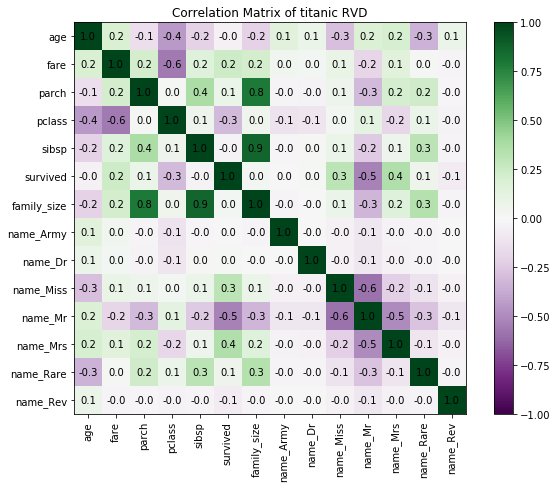

,age,fare,parch,pclass,sibsp,survived,family_size,name_Army,name_Dr,name_Miss,name_Mr,name_Mrs,name_Rare,name_Rev
age,1,0.197,-0.136,-0.445,-0.205,-0.038,-0.209,0.141,0.083,-0.282,0.183,0.205,-0.337,0.071
fare,0.197,1,0.222,-0.559,0.16,0.244,0.226,0.043,0.03,0.09,-0.192,0.142,0.017,-0.022
parch,-0.136,0.222,1,0.018,0.374,0.083,0.792,-0.021,-0.024,0.065,-0.306,0.215,0.24,-0.012
pclass,-0.445,-0.559,0.018,1,0.061,-0.312,0.05,-0.113,-0.098,0.025,0.119,-0.185,0.071,-0.028
sibsp,-0.205,0.16,0.374,0.061,1,-0.028,0.862,-0.015,0.009,0.076,-0.242,0.065,0.313,-0.019
survived,-0.038,0.244,0.083,-0.312,-0.028,1,0.027,0.007,0.019,0.306,-0.527,0.355,0.059,-0.062
family_size,-0.209,0.226,0.792,0.05,0.862,0.027,1,-0.021,-0.007,0.085,-0.326,0.16,0.337,-0.019
name_Army,0.141,0.043,-0.021,-0.113,-0.015,0.007,-0.021,1,-0.006,-0.037,-0.086,-0.031,-0.017,-0.006
name_Dr,0.083,0.03,-0.024,-0.098,0.009,0.019,-0.007,-0.006,1,-0.039,-0.092,-0.033,-0.018,-0.006
name_Miss,-0.282,0.09,0.065,0.025,0.076,0.306,0.085,-0.037,-0.039,1,-0.59,-0.213,-0.115,-0.039


<column_matrix>

In [64]:
titanic.corr()

Let's see the importance of being a doctor.

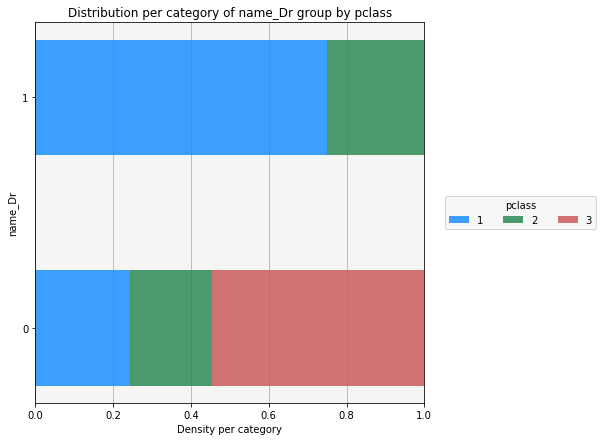

In [65]:
titanic.fully_stacked_bar(columns=["name_Dr","pclass"])

As expected, all the Doctors are in first or second class.

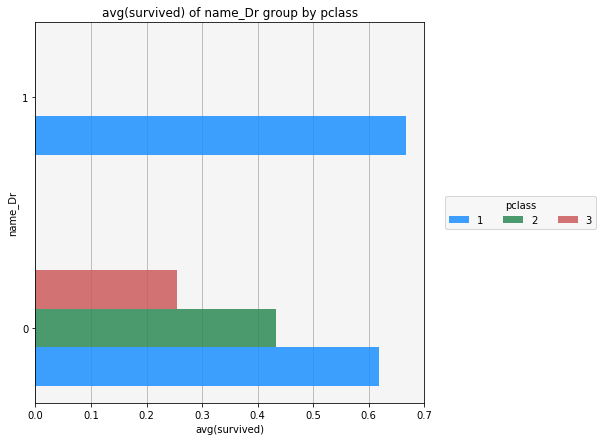

In [66]:
titanic.bar(columns=["name_Dr","pclass"],method="mean",of="survived")

Wow all the doctor in second class died and almost 70% in first class survived !

This variable is very interesting as the title seems to really influence the survival. We do not need a dummy encode as we will use a random forest classifier. However the response column must be categorical.

In [67]:
titanic["survived"].enum()
titanic.train_test_split()

The views test_titanic033 and train_titanic067 were successfully created.


,age,embarked,fare,name,parch,pclass,sibsp,survived,family_size,gender,name_Army,name_Dr,name_Miss,name_Mr,name_Mrs,name_Rare,name_Rev
0,63.0,S,221.77920,Mrs,0,1,1,0,2,female,0,0,0,0,1,0,0
1,60.0,C,75.25000,Mrs,0,1,1,1,2,female,0,0,0,0,1,0,0
2,60.0,S,263.00000,Mrs,4,1,1,1,6,female,0,0,0,0,1,0,0
3,59.0,S,51.47920,Mrs,0,1,2,1,3,female,0,0,0,0,1,0,0
4,58.0,C,146.52080,Miss,0,1,0,1,1,female,0,0,1,0,0,0,0
5,58.0,S,26.55000,Miss,0,1,0,1,1,female,0,0,1,0,0,0,0
6,58.0,S,153.46250,Mrs,1,1,0,1,2,female,0,0,0,0,1,0,0
7,58.0,C,512.32920,Mrs,1,1,0,1,2,female,0,0,0,0,1,0,0
8,56.0,C,83.15830,Mrs,1,1,0,1,2,female,0,0,0,0,1,0,0
9,55.0,C,27.72080,Mrs,0,1,0,1,1,female,0,0,0,0,1,0,0


,age,embarked,fare,name,parch,pclass,sibsp,survived,family_size,gender,name_Army,name_Dr,name_Miss,name_Mr,name_Mrs,name_Rare,name_Rev
0,76.0,S,78.85000,Mrs,0,1,1,1,2,female,0,0,0,0,1,0,0
1,64.0,S,26.55000,Mrs,1,1,1,1,3,female,0,0,0,0,1,0,0
2,64.0,C,83.15830,Mrs,2,1,0,1,3,female,0,0,0,0,1,0,0
3,63.0,S,77.95830,Miss,0,1,1,1,2,female,0,0,1,0,0,0,0
4,62.0,None,80.00000,Mrs,0,1,0,1,1,female,0,0,0,0,1,0,0
5,60.0,C,76.29170,Mrs,0,1,0,1,1,female,0,0,0,0,1,0,0
6,55.0,C,135.63330,Mrs,0,1,0,1,1,female,0,0,0,0,1,0,0
7,54.0,C,59.40000,Mrs,0,1,1,1,2,female,0,0,0,0,1,0,0
8,54.0,C,78.26670,Miss,0,1,1,1,2,female,0,0,1,0,0,0,0
9,53.0,S,51.47920,Mrs,0,1,2,1,3,female,0,0,0,0,1,0,0


(Name: train_titanic067, Number of rows: 897, Number of columns: 17,
 Name: test_titanic033, Number of rows: 409, Number of columns: 17)

Before building our RF model, let's see the logloss according to the number of trees.

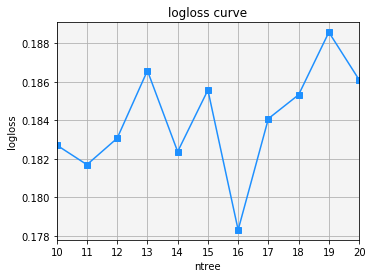

In [68]:
from vertica_ml_python import metric_rf_curve_ntree
logloss_curve=metric_rf_curve_ntree(input_relation='train_titanic067',test_relation='test_titanic033',response_column='survived',
                                     predictor_columns=["age","gender","family_size","embarked","pclass","name"],cursor=cur,test_only=True,
                                     ntree_begin=10,ntree_end=20)

In [69]:
import numpy
best_ntree=numpy.argmin(logloss_curve[0].data_columns[1][1:-1])+1

Thanks to this curve, we can see that the ideal number of trees seems to be around {{best_ntree}}. This information can be very useful when the dataset is huge. We have to remember that trees are huge victims of overfitting, that's why we need to be careful and to always analyse the test set. We are now ready to build the RF model.

In [70]:
from vertica_ml_python import rf_classifier
drop_model("rf_titanic",cur)
rf=rf_classifier(model_name="rf_titanic",input_relation="train_titanic067",response_column="survived",
                   predictor_columns=["age","gender","family_size","embarked","pclass","name"],cursor=cur,ntree=best_ntree)

The model rf_titanic was successfully dropped.


In [71]:
print(rf)

column,type
age,float
gender,char or varchar
family_size,int
embarked,char or varchar
pclass,int
name,char or varchar


model_type='rf_classifier'
model_name='rf_titanic'
input_relation='train_titanic067'
response_column='survived'
predictor_columns='age,gender,family_size,embarked,pclass,name'
tree_count: 7
rejected_row_count: 1
accepted_row_count: 896


We can see each tree using the tree method "tree(n=ID)"

In [72]:
rf.tree(n=0)

--------------------------------------------------------------------------------
Tree Id: 0
Number of Nodes: 45
Tree Depth: 5
Tree Breadth: 22
--------------------------------------------------------------------------------
[1]
├── [2] (name=Mr)
│   ├── [4] (age<18.6275)
│   │   ├── [8] (family_size<1.3125)
│   │   │   └── 0 (probability=0.941176)
│   │   └── [9] (family_size>=1.3125)
│   │       └── 0 (probability=1)
│   └── [5] (age>=18.6275)
│       ├── [10] (age<50.9281)
│       │   ├── [20] (pclass<1.0625)
│       │   │   ├── [40] (family_size<2.25)
│       │   │   │   └── 0 (probability=0.555556)
│       │   │   └── [41] (family_size>=2.25)
│       │   │       └── 0 (probability=1)
│       │   └── [21] (pclass>=1.0625)
│       │       ├── [42] (age<20.9347)
│       │       │   └── 0 (probability=0.666667)
│       │       └── [43] (age>=20.9347)
│       │           └── 0 (probability=0.870813)
│       └── [11] (age>=50.9281)
│           ├── [22] (age<62.4641)
│           │   ├── [

NodeID,Node Depth,isLeaf,isSplitCategorical,split on,threshold,leftChildID,rightChildID,prediction,probability
1,0,0,1,name,Mr,2,3,-,-
2,1,0,0,age,18.6275,4,5,-,-
4,2,0,0,family_size,1.3125,8,9,-,-
8,3,1,-,-,-,-,-,0,0.941176
9,3,1,-,-,-,-,-,0,1
5,2,0,0,age,50.9281,10,11,-,-
10,3,0,0,pclass,1.0625,20,21,-,-
20,4,0,0,family_size,2.25,40,41,-,-
40,5,1,-,-,-,-,-,0,0.555556
41,5,1,-,-,-,-,-,0,1


<column_matrix>

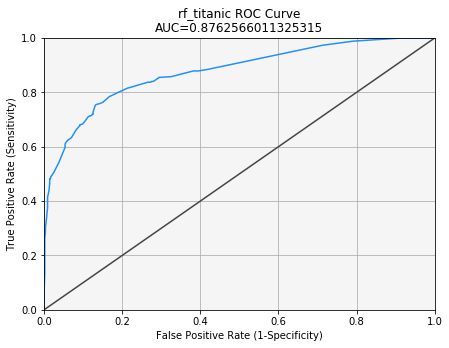

,error_rate
0,0.132616487455197
1,0.247787610619469
total,0.176142697881828


<column_matrix>


In [73]:
roc=rf.roc()
auc=rf.auc()
best_threshold=roc[0].data_columns[1][2]
accuracy=rf.accuracy()
print(rf.error_rate(threshold=best_threshold))

Wow We built a very good model with the RF classifier using new features ({{round(100*accuracy,2)}}% of accuracy and {{round(auc,2)}} AUC). Let's see if it is as good for the test set.

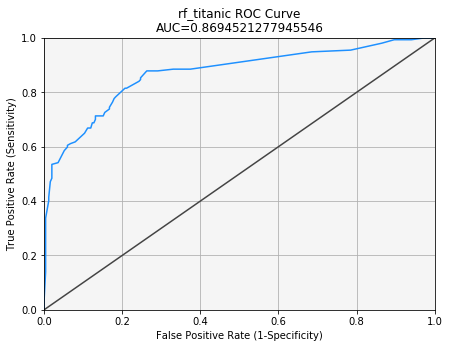

,error_rate
0,0.167330677290837
1,0.265822784810127
total,0.205378973105134


<column_matrix>

In [74]:
rf_test=load_model("rf_titanic",cur,input_relation="test_titanic033")
roc=rf_test.roc()
rf_test.error_rate(threshold=best_threshold)

The model is still good for the test and we created a better model than the first one !

### <font color='#555555'>Comparing metrics to scikit-learn [Random Forest]<font>

Let's compare again Vertica to scikit learn but this time with the random forest classifier. In order to use scikit random forest, we need some data preparation as the model does not accept non-numerical values and missing values (it can be very painful to do all these modifications).

In [75]:
titanic["gender"].label_encode()
titanic["name"].label_encode()
titanic["embarked"].label_encode()
titanic["fare"].dropna()
titanic["embarked"].dropna()

gender,encoding
female,0
male,1


The label encoding was successfully done.


name,encoding
Army,0
Rev,1
Dr,2
Rare,3
Mrs,4
Miss,5
Mr,6


The label encoding was successfully done.


embarked,encoding
Q,0
C,1
S,2


The label encoding was successfully done.
1 element was dropped
2 elements were dropped


We can then compare Vertica and scikit models.

In [76]:
from sklearn.ensemble import RandomForestClassifier

number_rounds=5
vertica_accuracy=[]
vertica_auc=[]
scikit_accuracy=[]
scikit_auc=[]
for i in range(number_rounds):
    # Split the data into two views
    drop_table("random_vpython_table_titanic",cur,print_info=False)
    titanic.train_test_split(print_info=False)
    
    # Scikit
    titanic_df_train=pandas.read_sql("select * from train_titanic067",conn)
    titanic_df_test=pandas.read_sql("select * from test_titanic033",conn)
    model=RandomForestClassifier(n_estimators=20,max_features=3,max_depth=5)
    model.fit(titanic_df_train[["age","embarked","fare","family_size","pclass","gender","name"]],titanic_df_train["survived"])
    # accuracy
    predicted=model.predict(titanic_df_test[["age","embarked","fare","family_size","pclass","gender","name"]])
    scikit_accuracy+=[accuracy_score(predicted,titanic_df_test["survived"])]
    # auc
    response=model.predict_proba(titanic_df_test[["age","embarked","fare","family_size","pclass","gender","name"]])
    scikit_auc+=[roc_auc_score([int(item) for item in titanic_df_test["survived"].tolist()],[item[1] for item in response])]
    
    # Vertica
    drop_model("rf_titanic",cur,print_info=False)
    rf=rf_classifier(model_name="rf_titanic",input_relation="train_titanic067",response_column="survived",
                    predictor_columns=["age","gender","family_size","embarked","pclass","name"],cursor=cur,ntree=20,
                    mtry=3,max_depth=5,sampling_size=1.0)
    rf_test=load_model("rf_titanic",cur,input_relation="test_titanic033")
    # accuracy
    vertica_accuracy+=[rf_test.accuracy()]
    # auc
    vertica_auc+=[rf_test.auc()] 

Let's now compare the different accuracies.

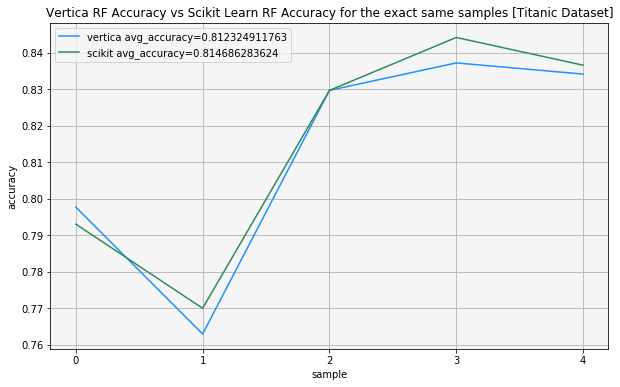

In [77]:
from matplotlib import pyplot as plt
import numpy
sample=list(range(number_rounds))

# accuracy
plt.figure(figsize=(10,6))
plt.plot(sample,vertica_accuracy,label="vertica avg_accuracy="+str(numpy.mean(vertica_accuracy)),color="dodgerblue")
plt.plot(sample,scikit_accuracy,label="scikit avg_accuracy="+str(numpy.mean(scikit_accuracy)),color="seagreen")
plt.ylabel('accuracy')
plt.xlabel('sample')
plt.legend()
plt.grid()
plt.xticks(sample,sample)
plt.title('Vertica RF Accuracy vs Scikit Learn RF Accuracy for the exact same samples [Titanic Dataset]')
plt.show()

Let's now compare the different auc.

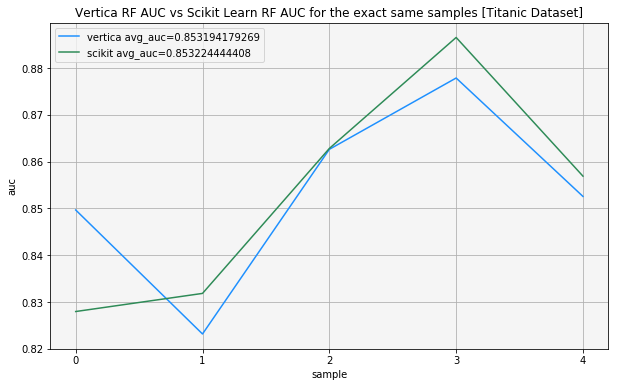

In [78]:
# auc
plt.figure(figsize=(10,6))
plt.plot(sample,vertica_auc,label="vertica avg_auc="+str(numpy.mean(vertica_auc)),color="dodgerblue")
plt.plot(sample,scikit_auc,label="scikit avg_auc="+str(numpy.mean(scikit_auc)),color="seagreen")
plt.ylabel('auc')
plt.xlabel('sample')
plt.legend()
plt.grid()
plt.xticks(sample,sample)
plt.title('Vertica RF AUC vs Scikit Learn RF AUC for the exact same samples [Titanic Dataset]')
plt.show()

And the winner is...
<br>
<br>
<img src="images/draw_match.png" width="600px">
<br>
<br>
Draw again ! Thanks to these graphs, we proved that Vertica RF has almost the same performance than scikit. In fact, some parameters of scikit are not in Vertica and reciprocally; besides, the randomness of the RF make it unpredictable that's why the results are not totally the same. At the end knowing the efficiency of Vertica, we can say that it is better to use Vertica RF than scikit...

### <font color='#555555'>Champion Challenger<font>
<br>
<br>
<img src="images/champion.png" width="400px">
<br>
<br>    
Let's now try to do a champion challenger of the 4 binomial models inside Vertica (SVM, Logit, RF and Naive Bayes). After this entire studies, we know the importance of each variable. For this contest, we need to have only numerical features. In order to have the best efficiency, we need to use one hot encoder of each categorical feature (except the ones that are numerical). We will use the default parameters and then try to optimize the champion.

In [79]:
# Data Preparation
titanic=RVD('titanic',cur)
titanic.drop_columns(columns=["body","cabin","boat","homedest"])
titanic.add_feature(alias="family_size",imputation="parch+sibsp+1")
titanic["fare"].dropna()
titanic["embarked"].dropna()
titanic["sex"].rename("gender")
titanic["gender"].label_encode()
titanic["age"].fillna(method="avg",by=["pclass","gender"])
titanic["fare"].transformations+=[("{}::float","float","float")]
titanic["name"].regexp_substr(' ([A-Za-z]+)\.')
titanic["name"].decode([" Mr."," Miss."," Mrs."," Ms."," Mlle."," Lady."," Mme."," Sir."," Rev."," Dr."," Col."," Major."," Capt."],
                        ["Mr","Miss","Mrs","Miss","Miss","Mrs","Mrs","Mr","Rev","Dr","Army","Army","Army"],"Rare")
titanic["name"].one_hot_encoder()
titanic["embarked"].one_hot_encoder()
titanic['name_Mr'].rename('is_Mr')
titanic['name_Miss'].rename('is_Miss')
titanic['name_Mrs'].rename('is_Mrs')
titanic['name_Rev'].rename('is_Rev')
titanic['name_Dr'].rename('is_Dr')
titanic['name_Army'].rename('is_Army')

RVC 'body' deleted from the RVD.
RVC 'cabin' deleted from the RVD.
RVC 'boat' deleted from the RVD.
RVC 'homedest' deleted from the RVD.
The new RVC 'family_size' was added to the RVD.
1 element was dropped
2 elements were dropped
RVC 'sex' renamed 'gender'


gender,encoding
female,0
male,1


The label encoding was successfully done.
263 elements were filled
7 new features: name_Army, name_Dr, name_Miss, name_Mr, name_Mrs, name_Rare, name_Rev
3 new features: embarked_C, embarked_Q, embarked_S
RVC 'name_Mr' renamed 'is_Mr'
RVC 'name_Miss' renamed 'is_Miss'
RVC 'name_Mrs' renamed 'is_Mrs'
RVC 'name_Rev' renamed 'is_Rev'
RVC 'name_Dr' renamed 'is_Dr'
RVC 'name_Army' renamed 'is_Army'


In [80]:
from vertica_ml_python import drop_view
# Saving the RVD
drop_view('titanic_temp',cur)
titanic.save('titanic_temp')

The view titanic_temp was successfully dropped.
The RVD was successfully saved.


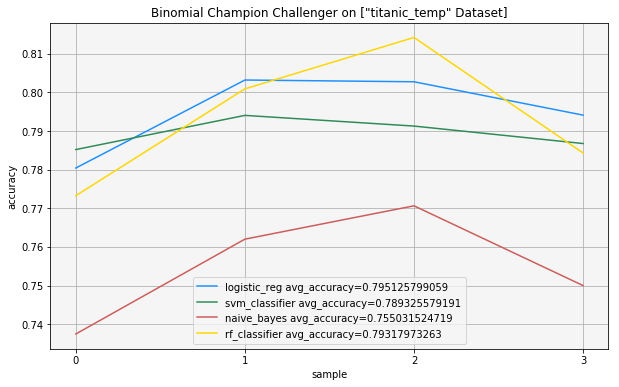

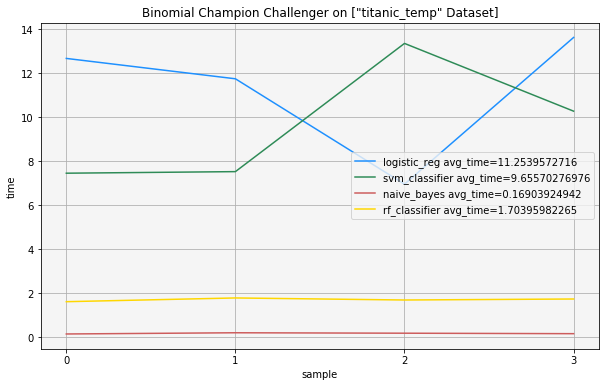

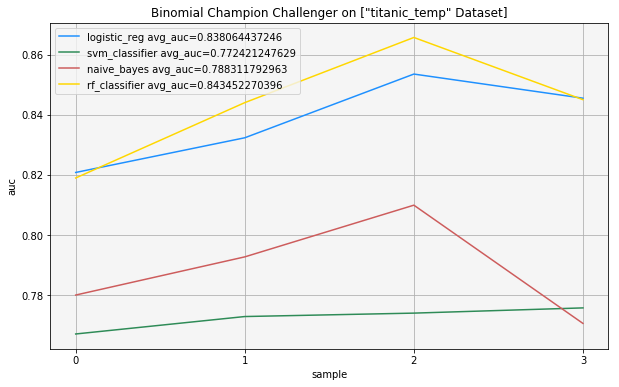

,avg_time,avg_auc,avg_accuracy,std_accuracy
logistic_reg,11.2539572716,0.838064437246,0.795125799059,0.00922510275102
svm_classifier,9.65570276976,0.772421247629,0.789325579191,0.00352545180474
naive_bayes,0.16903924942,0.788311792963,0.755031524719,0.012511614144
rf_classifier,1.70395982265,0.843452270396,0.79317973263,0.0156329456394


<column_matrix>

In [81]:
# Champion Challenger
from vertica_ml_python import champion_challenger_binomial
champion_challenger_binomial('titanic_temp','survived',['is_Army','is_Dr','is_Rev','is_Mrs','is_Miss',
                                'is_Mr','embarked_C','embarked_Q','embarked_S','fare','age','pclass',
                                'gender','family_size'],cur,logit_optimizer="BFGS",fold_count=4)

We can see that Naive Bayes is not good at all for this dataset. SVM, Logit and RF are really good (we can not really take into account the SVM auc as its ROC is only one point). However, RF is largely faster than the others. SVM can be an option as it is the algorithm that we can really understand and seems to be efficient for this dataset. Let's try to build the best model for both. 

In [82]:
from vertica_ml_python import cross_validate
drop_model('cv_svm_titanic',cur)
svm_cv=cross_validate('svm_classifier','titanic_temp','survived',['is_Army','is_Dr','is_Rev','is_Mrs','is_Miss',
                    'is_Mr','embarked_C','embarked_Q','embarked_S','fare','age','pclass','gender','family_size',
                    'parch','sibsp'],cur,model_name='cv_svm_titanic',fold_count=2,hyperparams='{"C":[1,5,10]}')

The model cv_svm_titanic was successfully dropped.


,counter_name,counter_value
0,accepted_row_count,1306
1,rejected_row_count,0
2,feature_count,16


,fold_id,row_count
0,0,635
1,1,671


,C,fold_id,iteration_count,accuracy,error_rate
0,1,0,13,0.804724409448819,0.195275590551181
1,1,1,13,0.810730253353204,0.189269746646796
2,5,0,12,0.809448818897638,0.190551181102362
3,5,1,15,0.806259314456036,0.193740685543964
4,10,0,12,0.809448818897638,0.190551181102362
5,10,1,15,0.806259314456036,0.193740685543964


,C,accuracy,error_rate
0,1,0.807727331401011,0.192272668598988
1,5,0.807854066676837,0.192145933323163
2,10,0.807854066676837,0.192145933323163


<cross_validate>


The only parameter which can modify the model has no real influence. Having this information, we know that we can not improve this SVM whereas it is possible to improve the random forest. Let's try...

The views test_titanic_temp033 and train_titanic_temp067 were successfully created.


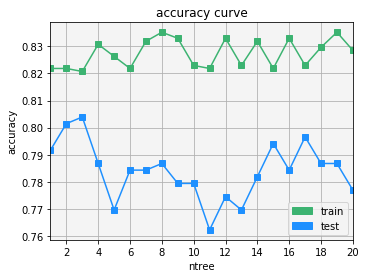

In [83]:
from vertica_ml_python import metric_rf_curve_ntree
titanic=RVD('titanic_temp',cur)
titanic["survived"].enum()
titanic.train_test_split()
accuracy_curve=metric_rf_curve_ntree(input_relation='train_titanic_temp067',test_relation='test_titanic_temp033',response_column='survived',
                                     predictor_columns=['is_Army','is_Dr','is_Rev','is_Mrs','is_Miss','is_Mr','embarked_C','embarked_Q','embarked_S',
                                    'fare','age','pclass','gender','family_size','parch','sibsp'],cursor=cur,mode='accuracy',ntree_begin=1,ntree_end=20,
                                     max_breadth=1000,test_only=False,sampling_size=1.0)

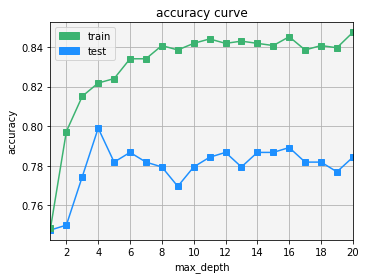

In [84]:
from vertica_ml_python import metric_rf_curve_depth
accuracy_curve=metric_rf_curve_depth(input_relation='train_titanic_temp067',test_relation='test_titanic_temp033',response_column='survived',
                                     predictor_columns=['is_Army','is_Dr','is_Rev','is_Mrs','is_Miss','is_Mr','embarked_C','embarked_Q','embarked_S',
                                    'fare','age','pclass','gender','family_size','parch','sibsp'],cursor=cur,mode='accuracy',max_depth_begin=1,max_depth_end=20,
                                    max_breadth=1000,test_only=False,sampling_size=1.0)

We can increase the max depth but the result will be overfitting. At the end, a small number of tree (15 for example) and a small max depth (6 for example) are reasonable for this dataset.

In [85]:
drop_model("rf_titanic",cur)
rf=rf_classifier(model_name="rf_titanic",input_relation="train_titanic_temp067",response_column="survived",
                   predictor_columns=['is_Army','is_Dr','is_Rev','is_Mrs','is_Miss','is_Mr','embarked_C','embarked_Q','embarked_S',
                    'fare','age','pclass','gender','family_size','parch','sibsp'],cursor=cur,ntree=15,max_depth=6,
                    max_breadth=1000)

The model rf_titanic was successfully dropped.


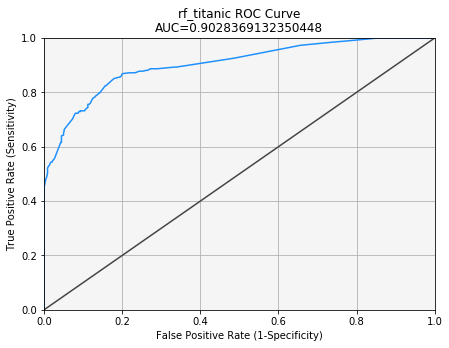

,error_rate
0,0.0925266903914591
1,0.267857142857143
total,0.158129175946548


<column_matrix>

In [86]:
rf.roc()
rf.error_rate()

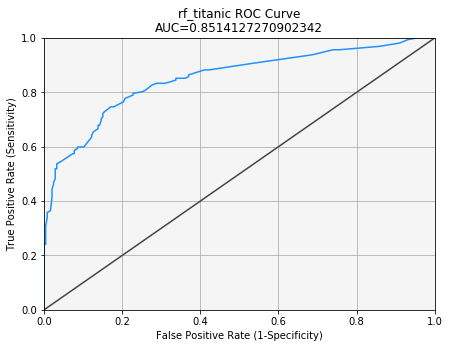

,error_rate
0,0.142276422764228
1,0.320987654320988
total,0.213235294117647


<column_matrix>

In [87]:
rf_test=load_model("rf_titanic",cur,input_relation="test_titanic_temp033")
rf_test.roc()
rf_test.error_rate()

We can also see the influence of the threshold on the accuracy.

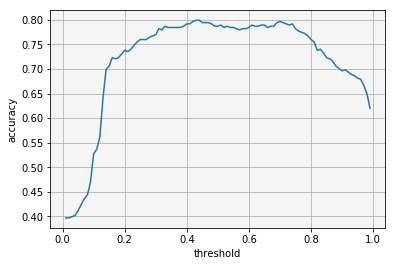

In [88]:
all_accuracy=[]
all_threshold=[]
for i in range(1,100):
    threshold=float(i/100)
    all_threshold+=[threshold]
    all_accuracy+=[rf_test.accuracy(threshold=threshold)]
plt.grid()
plt.plot(all_threshold,all_accuracy)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

A good threshold has to be between 0.4 and 0.6 The default threshold is then still good. To conclude, the model we created is very good for this dataset.

### <font color='#555555'>Exploring wrong predictions<font>

We can also add the prediction to the test RVD in order to see where are the algorithm mistakes.

In [89]:
titanic_test=RVD('test_titanic_temp033',cur)
name=rf_test.add_to_rvd(titanic_test)
titanic_test.add_feature('prediction_val',titanic_test[name].transformations[0][0]+'=survived')
titanic_test.filter('prediction_val=False')
titanic_test["survived"].convert_to_num()

The new RVC 'rf_classifier_pred3525' was added to the RVD.
The new RVC 'prediction_val' was added to the RVD.
318 elements were filtered


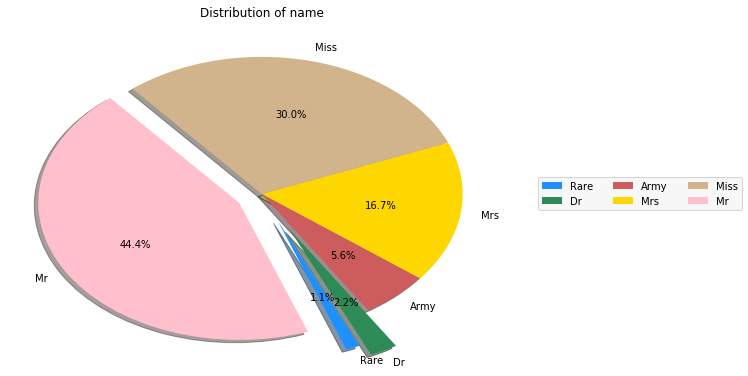

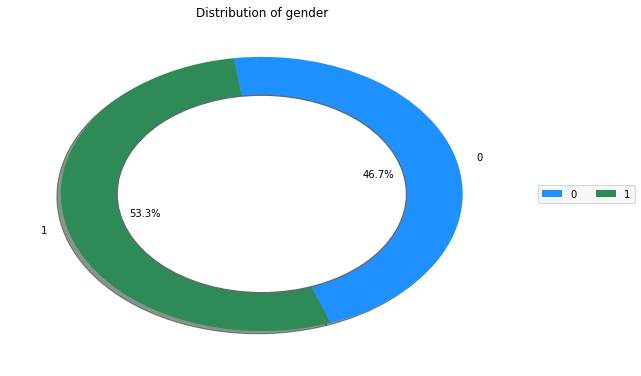

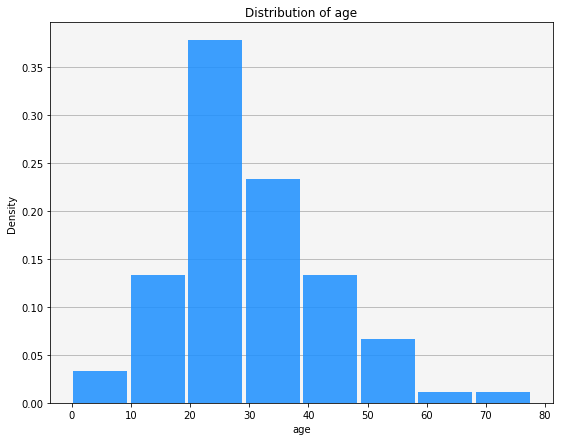

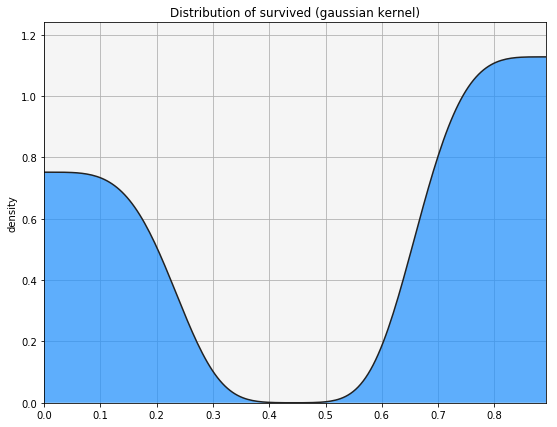

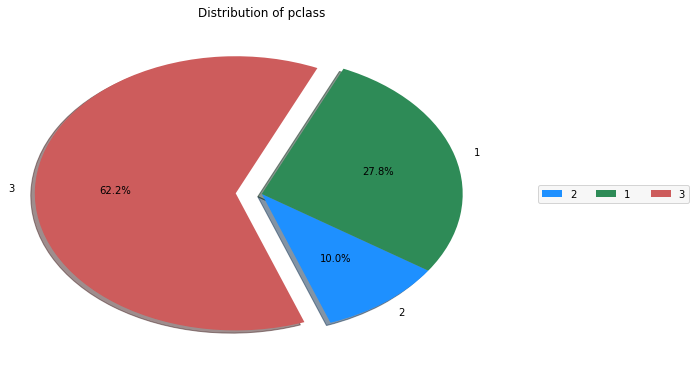

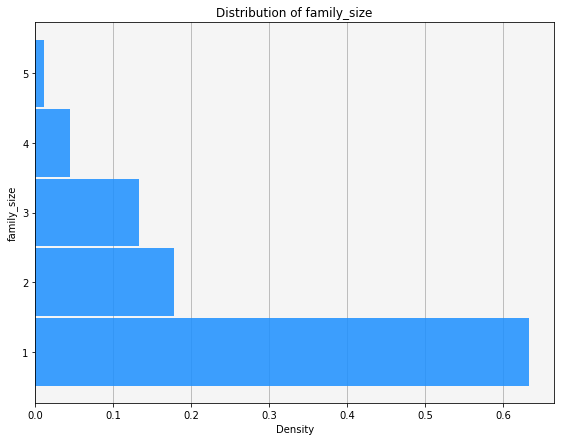

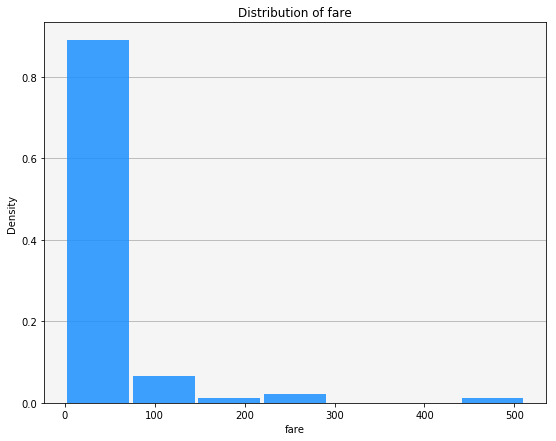

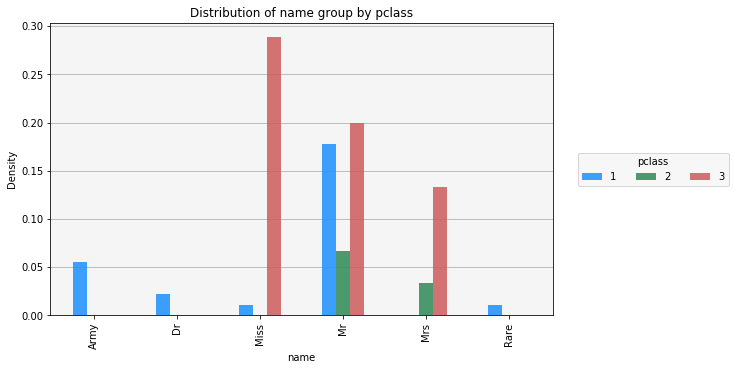

In [90]:
titanic_test['name'].pie()
titanic_test['gender'].donut()
titanic_test['age'].hist()
titanic_test['survived'].density()
titanic_test['pclass'].pie()
titanic_test['family_size'].bar()
titanic_test['fare'].hist()
titanic_test.hist(columns=['name','pclass'])

The algorithm is not really good on women in 3rd class and men in 1st class which make sense. Let's see what happened for the men in 3rd class where the prediction is wrong.

In [91]:
titanic_test.filter("name='Mr' and pclass=3")

72 elements were filtered


In [92]:
titanic_test.select(['age','family_size','fare','embarked','survived','ticket'])

,age,family_size,fare,embarked,survived,ticket
0,44.0,1,7.925,S,1.0,STON/O 2. 3101269
1,32.0,1,56.4958,S,1.0,1601
2,32.0,1,56.4958,S,1.0,1601
3,31.0,1,7.925,S,1.0,STON/O 2. 3101288
4,29.0,1,9.5,S,1.0,345779
5,25.0,1,9.5,S,1.0,345768
6,25.0,1,7.2292,C,1.0,2654
7,22.0,1,7.225,C,1.0,2620
8,22.0,1,7.225,C,1.0,2658
9,20.0,2,7.925,S,1.0,STON/O 2. 3101285


<column_matrix>

Wow, some of the men in 3rd class survived and we can not do anything to predict their survival. They have the perfect characteristics of people who died. Finally, we do not have enough raws to improve the model. The only way to improve it is to use the features we deleted and this task can be really hard (most of them have a lot of missing values except ticket). [The 'ticket' column can be interesting for a next step !]
<br>
<img src="images/titanic_plan.png" width="850px">
<br>
### <font color='#555555'>Conclusion<font>

We can conclude that during the titanic sinking...
<br>
<img src="images/titanic_sinking.png" width="350px">
<br>
He probably survived...
<br>
<img src="images/titanic_man.png" width="300px">
<br>
She survived...
<br>
<img src="images/titanic_woman.png" width="300px">
<br>
And they died...
<br>
<img src="images/titanic_workers.png" width="600px">
<br>
And it is not probably thanks to Jack that Rose survived but because the crew tried to evacuate the children and women first...
<br>
<img src="images/titanic_movie.png" width="600px">
<br>
So Rose had a huge probability to use lifeboats whereas it is less possible that she stayed with Jack. We finally discovered this BIG lie: Love is not always the key, sometimes we need to be smart and run...
<br>
<img src="images/titanic_lifeboat.png" width="600px">
<br>
At the end, exploring and cleaning the dataset is very important. The final stage is building a strong model for predictions and doing everything using the power of Vertica can be easy and very efficient using Vertica ML Python.
<br>
<img src="images/vertica.png" width="600px">
<br>
### <font color='#1e90ff'>About me<font>

<br>

<div style="float:right;margin-left:30px;"><img src="images/about.png" width="520px"></div>

<div style="text-align:justify;">My name is Badr. I'm a young datascientist working with the best company ever. Vertica is for me the futur of big data. I'm passionate about mathematics, computer science and specially about datascience which allies both. I like learning from others and teaching what I know.<br><br>
<img src="images/vpython.png" width="200px">
</div>

### <font color='#1e90ff'>To contact me<font>
<b>@: </b><a href="mailto:badr.ouali@microfocus.com">badr.ouali@microfocus.com</a><br>
<b>In: </b><a href="https://www.linkedin.com/in/badr-ouali/">badr-ouali</a>